In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm 
from torch.nn import init
import random

np.random.seed(21)

/home/abhishek/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Data:
    TABLE_SIZE = 1e8
    def __init__(self,training_data,min_freq,to_be_discard_size):
        self.training_data = training_data
        self.min_freq = min_freq
        self.to_be_discard_size = to_be_discard_size
        self.word2index = {}
        self.index2word = {}
        self.word_freq = {}
        self.sentence_count = 0 
        self.words_count = 0
        self.vocab_size = 0
        self.negatives = []
        self.subSampleTable = []
        self.negativePos = 0
        self.generateWords()
        self.generateNegatives()
        self.generateSubSampleTable()
        

    def generateWords(self):
        temp_dict = {}
        for sentence in self.training_data:
            sentence = sentence.split()
            if len(sentence) < 2:
                continue
            self.sentence_count += 1
            for word in sentence:
                if len(word) < 1:
                    continue
                self.words_count += 1
                if word not in temp_dict:
                    temp_dict[word] = 1
                else:
                    temp_dict[word] += 1
                if self.words_count %(1e6) == 0:
                    print("Processed {} M tokens".format(self.words_count))
        # indexing words for words , start, end and padding
        self.word2index = {'<PAD>':0,'<S>':1,'</S>':2}
        self.index2word = {0:'<PAD>',1:'<S>',2:'</S>'}
        self.word_freq = {'<PAD>':1,'<S>':1,'</S>':1}
        for word,cnt in temp_dict.items():
            # if cnt >= self.min_freq:
            self.word2index[word] = len(self.word2index)
            self.index2word[len(self.index2word)] = word
            self.word_freq[word] = cnt

        self.vocab_size = len(self.word2index)
        print("Vocab size is {}".format(self.vocab_size))
        print("Total number of words {}".format(self.words_count))
        print("Total number of sentences {}".format(self.sentence_count))

    def generateNegatives(self):
        newFreqWords = []
        for word in self.word_freq:
            newFreqWords.append(self.word_freq[word])
        newFreqWords = np.array(newFreqWords)**0.75
        newFreqWords = newFreqWords/np.sum(newFreqWords)
        self.negatives = np.random.choice(len(newFreqWords),size=int(Data.TABLE_SIZE),p=newFreqWords)
        print("Negative samples generated")

    def generateSubSampleTable(self):
        # f = sqrt(t/f) + t/f
        fr = np.array(list(self.word_freq.values()))
        fr = fr/np.sum(fr)
        fr = np.sqrt(1e-3/fr) + 1e-3/fr
        self.subSampleTable = np.round(fr * self.TABLE_SIZE)
        print("Subsample table generated")

    def getNegativeSamples(self,target):
        negSamples = []
        while len(negSamples) < self.to_be_discard_size:
            neg = self.negatives[self.negativePos]
            self.negativePos = (self.negativePos + 1) % len(self.negatives)
            if neg not in negSamples and neg != target:
                negSamples.append(neg)

        if len(negSamples) != self.to_be_discard_size:
            return np.concatenate((negSamples,self.negatives[:self.to_be_discard_size-len(negSamples)]))
        return negSamples



In [4]:
class Word2vecDataLoader(Dataset):
    def __init__(self, data, windowSize):
        self.data = data
        self.windowSize = windowSize
        self.word2index = data.word2index
        self.index2word = data.index2word
        self.word_freq = data.word_freq
        self.subSampleTable = data.subSampleTable
        self.negatives = data.negatives
        self.length = data.sentence_count

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sentence = self.data.training_data[idx].split()
        if len(sentence) < 2:
            # Can not return none as it will throw error
            if idx+1 == self.length:
                idx = 0
            return self.__getitem__(idx+1)
        sentence_ids = [self.word2index[word] for word in sentence if word in self.word2index and np.random.rand() < self.subSampleTable[self.word2index[word]]]
        padded_sent = [self.word2index['<S>']] + sentence_ids + [self.word2index['</S>']]
        cbowData = []
        szOneSide = self.windowSize//2
        for ind,word in enumerate(padded_sent):
            if ind == 0 or ind == len(padded_sent)-1:
                continue
            start = max(0,ind-szOneSide)
            end = min(len(padded_sent)-1,ind+szOneSide)
            context = [padded_sent[i] for i in range(start,end+1) if i != ind]
            if len(context) < 2*(szOneSide):
                context += [self.word2index['<PAD>']]*(2*(szOneSide)-len(context))
            
            cbowData.append((context,word,self.data.getNegativeSamples(word)))

        return cbowData
    
    @staticmethod
    def collate_fn(batches):
        targ_batch = [u for batch in batches for u,v,n in batch if len(batch) > 0]
        context_batch = [v for batch in batches for u,v,n in batch if len(batch) > 0]
        neg_batch = [n for batch in batches for u,v,n in batch if len(batch) > 0]

        return torch.LongTensor(context_batch),torch.LongTensor(targ_batch),torch.LongTensor(neg_batch)
    

class skipGramModule(nn.Module):
    def __init__(self,vocab_size,embedding_size):
        super(skipGramModule,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.targetEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        self.contextEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        initrange = 1.0/self.embedding_size
        init.uniform_(self.targetEmbedding.weight.data,-initrange,initrange)
        init.constant_(self.contextEmbedding.weight.data,0)

    def forward(self,context,target,negatives):
        trg_embedding = self.targetEmbedding(target)
        trg_embedding = torch.mean(trg_embedding,dim=1)
        context_embedding = self.contextEmbedding(context)
        neg_embedding = self.contextEmbedding(negatives)

        pos_score = torch.sum(
            torch.mul(trg_embedding, context_embedding), dim=1)
        pos_score = torch.clamp(pos_score,max=10,min=-10)
        pos_score = -F.logsigmoid(pos_score)

        neg_score = torch.bmm(neg_embedding,torch.unsqueeze(trg_embedding,2)).squeeze()
        neg_score = torch.clamp(neg_score,max=10,min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score),dim=1)

        return torch.mean(pos_score+neg_score)
    
    def embeddingSave(self,ind2word,output_file):
        embedding = self.targetEmbedding.weight.data.cpu().numpy()
        with open(output_file,'w') as f:
            f.write('{} {}\n'.format(len(ind2word),self.embedding_size))
            for word_id,word in ind2word.items():
                tmp = ' '.join(map(lambda x: str(x),embedding[word_id]))
                f.write('{} {}\n'.format(word,tmp))




In [6]:
EMBEDDING_DIM = 300
BATCH_SIZE = 128
WINDOW_SIZE = 9
EPOCHS = 10
LEARNING_RATE = 0.001
NEGATIVE_SAMPLES = 5
MIN_FREQ = 5

In [7]:
class CBOW:
    def __init__(self,training_data,output_file):
        self.data = Data(training_data,min_freq=MIN_FREQ,to_be_discard_size=NEGATIVE_SAMPLES)
        compData = Word2vecDataLoader(self.data,WINDOW_SIZE)
        self.dataloader = DataLoader(compData,batch_size=BATCH_SIZE,shuffle=True,collate_fn=compData.collate_fn)
        self.embedding_size = len(self.data.word2index)
        self.embedding_dim = EMBEDDING_DIM
        self.model = skipGramModule(self.embedding_size, self.embedding_dim)
        self.use_cuda = torch.cuda.is_available()
        self.output_file = output_file
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.model.cuda()

    def train(self):
        optimizer = optim.SparseAdam(self.model.parameters(),lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,len(self.dataloader),eta_min=0.0001)
        for epoch in range(EPOCHS):
            total_loss = 0.0
            for i,(context,target,negatives) in enumerate(tqdm(self.dataloader)):
                if len(context) == 0:
                    continue
                cont = context.to(self.device)
                targ = target.to(self.device)
                neg = negatives.to(self.device)
                optimizer.step()
                optimizer.zero_grad()
                loss = self.model.forward(cont,targ,neg)
                loss.backward()
                scheduler.step()

                total_loss = total_loss*0.9 + loss.item()*0.1
                if i > 0 and i % 100 == 0:
                    print('Epoch: {} | Batch: {} | Loss: {}'.format(epoch,i,total_loss))
            print('Epoch: {} | Loss: {}'.format(epoch,total_loss))
        self.model.embeddingSave(self.data.index2word,self.output_file)

                

In [41]:
import pickle as pkl
training_data = []

with open('../../Data/smallData.pkl', 'rb') as fp:
    training_data = pkl.load(fp)


In [8]:
dataLines = []
with open("../../Data/preProcess.txt") as file:
    for line in tqdm(file):
        if line == " ":
            continue
        dataLines.append(line)

print("Number of lines: ", len(dataLines))


4607047it [00:15, 302970.66it/s]


Number of lines:  4607047


In [9]:
data = Data(dataLines[:100000], min_freq=5, to_be_discard_size=5)

# size of word2index


Processed 1000000 M tokens
Processed 2000000 M tokens
Processed 3000000 M tokens
Processed 4000000 M tokens
Processed 5000000 M tokens
Processed 6000000 M tokens
Processed 7000000 M tokens
Processed 8000000 M tokens
Processed 9000000 M tokens
Processed 10000000 M tokens
Processed 11000000 M tokens
Processed 12000000 M tokens
Vocab size is 25092
Total number of words 12772243
Total number of sentences 99917
Negative samples generated
Subsample table generated


In [10]:
print(data.word2index["cavani"])

KeyError: 'cavani'

In [12]:
output_file = 'embeddings.txt'

cbow = CBOW(dataLines[:100000], output_file)
cbow.train()


Processed 1000000 M tokens
Processed 2000000 M tokens
Processed 3000000 M tokens
Processed 4000000 M tokens
Processed 5000000 M tokens
Processed 6000000 M tokens
Processed 7000000 M tokens
Processed 8000000 M tokens
Processed 9000000 M tokens
Processed 10000000 M tokens
Processed 11000000 M tokens
Processed 12000000 M tokens
Vocab size is 25092
Total number of words 12772243
Total number of sentences 99917
Negative samples generated
Subsample table generated


 13%|█▎        | 101/781 [02:13<04:43,  2.40it/s] 

Epoch: 0 | Batch: 100 | Loss: 2.6700753958242878


 26%|██▌       | 201/781 [02:56<04:36,  2.10it/s]

Epoch: 0 | Batch: 200 | Loss: 2.527815076411701


 39%|███▊      | 301/781 [03:42<04:00,  2.00it/s]

Epoch: 0 | Batch: 300 | Loss: 2.514639124070166


 51%|█████▏    | 401/781 [04:27<03:06,  2.04it/s]

Epoch: 0 | Batch: 400 | Loss: 2.5062794069175407


 64%|██████▍   | 501/781 [05:13<02:10,  2.15it/s]

Epoch: 0 | Batch: 500 | Loss: 2.4994820480548072


 77%|███████▋  | 601/781 [06:01<01:18,  2.29it/s]

Epoch: 0 | Batch: 600 | Loss: 2.500281742537892


 90%|████████▉ | 701/781 [06:52<00:42,  1.87it/s]

Epoch: 0 | Batch: 700 | Loss: 2.500234996094537


100%|██████████| 781/781 [07:28<00:00,  1.74it/s]


Epoch: 0 | Loss: 2.4955420144754528


 13%|█▎        | 101/781 [00:48<05:09,  2.20it/s]

Epoch: 1 | Batch: 100 | Loss: 2.493703412278602


 26%|██▌       | 201/781 [01:36<04:25,  2.18it/s]

Epoch: 1 | Batch: 200 | Loss: 2.483967434929984


 39%|███▊      | 301/781 [02:25<03:35,  2.22it/s]

Epoch: 1 | Batch: 300 | Loss: 2.479734976779376


 51%|█████▏    | 401/781 [03:11<02:50,  2.23it/s]

Epoch: 1 | Batch: 400 | Loss: 2.461283684374775


 64%|██████▍   | 501/781 [04:00<02:11,  2.13it/s]

Epoch: 1 | Batch: 500 | Loss: 2.4333091093745063


 77%|███████▋  | 601/781 [04:48<01:23,  2.14it/s]

Epoch: 1 | Batch: 600 | Loss: 2.405998593162397


 90%|████████▉ | 701/781 [05:40<00:35,  2.27it/s]

Epoch: 1 | Batch: 700 | Loss: 2.37056933578325


100%|██████████| 781/781 [06:18<00:00,  2.06it/s]


Epoch: 1 | Loss: 2.330003151777795


 13%|█▎        | 101/781 [00:48<05:02,  2.25it/s]

Epoch: 2 | Batch: 100 | Loss: 2.2837634743571185


 26%|██▌       | 201/781 [01:38<05:34,  1.73it/s]

Epoch: 2 | Batch: 200 | Loss: 2.248834521161246


 39%|███▊      | 301/781 [02:29<05:19,  1.50it/s]

Epoch: 2 | Batch: 300 | Loss: 2.203586206153858


 51%|█████▏    | 401/781 [03:27<03:01,  2.09it/s]

Epoch: 2 | Batch: 400 | Loss: 2.1754918044764526


 64%|██████▍   | 501/781 [04:17<02:12,  2.11it/s]

Epoch: 2 | Batch: 500 | Loss: 2.156378750330248


 77%|███████▋  | 601/781 [05:08<01:18,  2.29it/s]

Epoch: 2 | Batch: 600 | Loss: 2.1500272298883387


 90%|████████▉ | 701/781 [05:57<00:37,  2.14it/s]

Epoch: 2 | Batch: 700 | Loss: 2.137982323254793


100%|██████████| 781/781 [06:37<00:00,  1.96it/s]


Epoch: 2 | Loss: 2.1387214516294395


 13%|█▎        | 101/781 [00:49<05:57,  1.90it/s]

Epoch: 3 | Batch: 100 | Loss: 2.128810528029013


 26%|██▌       | 201/781 [01:48<07:30,  1.29it/s]

Epoch: 3 | Batch: 200 | Loss: 2.125397829920963


 39%|███▊      | 301/781 [02:45<03:45,  2.13it/s]

Epoch: 3 | Batch: 300 | Loss: 2.113893973120969


 51%|█████▏    | 401/781 [03:37<03:09,  2.00it/s]

Epoch: 3 | Batch: 400 | Loss: 2.0983769773887393


 64%|██████▍   | 501/781 [04:27<02:31,  1.85it/s]

Epoch: 3 | Batch: 500 | Loss: 2.085481701204072


 77%|███████▋  | 601/781 [05:17<01:21,  2.22it/s]

Epoch: 3 | Batch: 600 | Loss: 2.063210918511562


 90%|████████▉ | 701/781 [06:06<00:36,  2.17it/s]

Epoch: 3 | Batch: 700 | Loss: 2.0396043754369306


100%|██████████| 781/781 [06:48<00:00,  1.91it/s]


Epoch: 3 | Loss: 2.03464913281766


 13%|█▎        | 101/781 [00:51<06:39,  1.70it/s]

Epoch: 4 | Batch: 100 | Loss: 2.00728633422618


 26%|██▌       | 201/781 [01:42<04:59,  1.94it/s]

Epoch: 4 | Batch: 200 | Loss: 1.9874578583022902


 39%|███▊      | 301/781 [02:31<03:43,  2.15it/s]

Epoch: 4 | Batch: 300 | Loss: 1.9854863586391427


 51%|█████▏    | 401/781 [03:21<02:51,  2.22it/s]

Epoch: 4 | Batch: 400 | Loss: 1.9621432466106148


 64%|██████▍   | 501/781 [04:09<02:22,  1.97it/s]

Epoch: 4 | Batch: 500 | Loss: 1.9525090228482151


 77%|███████▋  | 601/781 [05:02<01:37,  1.84it/s]

Epoch: 4 | Batch: 600 | Loss: 1.9568249193362566


 90%|████████▉ | 701/781 [05:52<00:38,  2.06it/s]

Epoch: 4 | Batch: 700 | Loss: 1.9425967527649246


100%|██████████| 781/781 [06:33<00:00,  1.98it/s]


Epoch: 4 | Loss: 1.9484148431699204


 13%|█▎        | 101/781 [00:50<06:37,  1.71it/s]

Epoch: 5 | Batch: 100 | Loss: 1.9384488755226041


 26%|██▌       | 201/781 [01:40<04:25,  2.19it/s]

Epoch: 5 | Batch: 200 | Loss: 1.9312636307683069


 39%|███▊      | 301/781 [02:32<03:55,  2.04it/s]

Epoch: 5 | Batch: 300 | Loss: 1.9394619582491326


 51%|█████▏    | 401/781 [03:21<04:21,  1.45it/s]

Epoch: 5 | Batch: 400 | Loss: 1.9387491087688304


 64%|██████▍   | 501/781 [04:12<02:35,  1.80it/s]

Epoch: 5 | Batch: 500 | Loss: 1.9163845771127939


 77%|███████▋  | 601/781 [05:03<01:23,  2.16it/s]

Epoch: 5 | Batch: 600 | Loss: 1.9091982210108212


 90%|████████▉ | 701/781 [05:52<00:38,  2.09it/s]

Epoch: 5 | Batch: 700 | Loss: 1.9121544274894335


100%|██████████| 781/781 [06:32<00:00,  1.99it/s]


Epoch: 5 | Loss: 1.899220980513338


 13%|█▎        | 101/781 [00:48<05:55,  1.92it/s]

Epoch: 6 | Batch: 100 | Loss: 1.8895710889789603


 26%|██▌       | 201/781 [01:38<04:51,  1.99it/s]

Epoch: 6 | Batch: 200 | Loss: 1.8756094797818916


 39%|███▊      | 301/781 [02:27<03:44,  2.13it/s]

Epoch: 6 | Batch: 300 | Loss: 1.8675692443850438


 51%|█████▏    | 401/781 [03:16<02:55,  2.17it/s]

Epoch: 6 | Batch: 400 | Loss: 1.8664956772586032


 64%|██████▍   | 501/781 [04:09<02:34,  1.82it/s]

Epoch: 6 | Batch: 500 | Loss: 1.8593173295839496


 77%|███████▋  | 601/781 [04:59<01:38,  1.82it/s]

Epoch: 6 | Batch: 600 | Loss: 1.8613242496859113


 90%|████████▉ | 701/781 [05:54<00:43,  1.83it/s]

Epoch: 6 | Batch: 700 | Loss: 1.8648889277749001


100%|██████████| 781/781 [06:34<00:00,  1.98it/s]


Epoch: 6 | Loss: 1.848425298380594


 13%|█▎        | 101/781 [00:49<04:57,  2.29it/s]

Epoch: 7 | Batch: 100 | Loss: 1.8430036566192785


 26%|██▌       | 201/781 [01:39<05:16,  1.83it/s]

Epoch: 7 | Batch: 200 | Loss: 1.8472345279648092


 39%|███▊      | 301/781 [02:30<04:14,  1.89it/s]

Epoch: 7 | Batch: 300 | Loss: 1.8443777350783062


 51%|█████▏    | 401/781 [03:20<02:53,  2.19it/s]

Epoch: 7 | Batch: 400 | Loss: 1.8397414001335242


 64%|██████▍   | 501/781 [04:09<02:30,  1.86it/s]

Epoch: 7 | Batch: 500 | Loss: 1.8416839066261252


 77%|███████▋  | 601/781 [05:00<01:15,  2.39it/s]

Epoch: 7 | Batch: 600 | Loss: 1.8346148085245897


 90%|████████▉ | 701/781 [05:50<00:37,  2.16it/s]

Epoch: 7 | Batch: 700 | Loss: 1.8232015694874564


100%|██████████| 781/781 [06:32<00:00,  1.99it/s]


Epoch: 7 | Loss: 1.8233912591103147


 13%|█▎        | 101/781 [00:50<05:54,  1.92it/s]

Epoch: 8 | Batch: 100 | Loss: 1.815090188860945


 26%|██▌       | 201/781 [01:40<04:47,  2.02it/s]

Epoch: 8 | Batch: 200 | Loss: 1.8128744774149421


 39%|███▊      | 301/781 [02:30<03:46,  2.12it/s]

Epoch: 8 | Batch: 300 | Loss: 1.8053421320667125


 51%|█████▏    | 401/781 [03:20<02:59,  2.11it/s]

Epoch: 8 | Batch: 400 | Loss: 1.7985981705366885


 64%|██████▍   | 501/781 [04:08<02:27,  1.90it/s]

Epoch: 8 | Batch: 500 | Loss: 1.7925679391629468


 77%|███████▋  | 601/781 [04:58<01:36,  1.87it/s]

Epoch: 8 | Batch: 600 | Loss: 1.8031215256977797


 90%|████████▉ | 701/781 [05:50<00:45,  1.76it/s]

Epoch: 8 | Batch: 700 | Loss: 1.804692811629903


100%|██████████| 781/781 [06:39<00:00,  1.96it/s]


Epoch: 8 | Loss: 1.7917939847184163


 13%|█▎        | 101/781 [00:51<05:43,  1.98it/s]

Epoch: 9 | Batch: 100 | Loss: 1.788838130001179


 26%|██▌       | 201/781 [01:41<04:38,  2.08it/s]

Epoch: 9 | Batch: 200 | Loss: 1.7774912936347558


 39%|███▊      | 301/781 [02:31<03:59,  2.01it/s]

Epoch: 9 | Batch: 300 | Loss: 1.792116706784859


 51%|█████▏    | 401/781 [03:22<03:18,  1.92it/s]

Epoch: 9 | Batch: 400 | Loss: 1.790470670728838


 64%|██████▍   | 501/781 [04:13<02:11,  2.13it/s]

Epoch: 9 | Batch: 500 | Loss: 1.7798828191684164


 77%|███████▋  | 601/781 [05:05<01:31,  1.98it/s]

Epoch: 9 | Batch: 600 | Loss: 1.776906632130603


 90%|████████▉ | 701/781 [05:56<00:43,  1.83it/s]

Epoch: 9 | Batch: 700 | Loss: 1.781536782456274


100%|██████████| 781/781 [06:37<00:00,  1.97it/s]


Epoch: 9 | Loss: 1.778726837365687


In [8]:
!pip3 install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 4.3 MB/s eta 0:00:0000:0100:01


In [23]:
import gensim
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import argparse


def colorBars(words, cbow_own,fileName):
    fig, axs = plt.subplots(nrows=len(words), ncols=1,
                            figsize=(20, 2*len(words)))
    color = ['brown', 'red', 'orange', 'yellow',
             'white', 'cyan', 'blue', 'purple', 'black']
    for i, word in enumerate(words):
        vec = cbow_own[word]
        vec = vec/np.linalg.norm(vec)
        axs[i].bar(range(300), vec, color=color)
        axs[i].set_title(word)

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()

def plot_top10_words(word, cbow_own):

    def tsne_plot(results):
        words = [x[0] for x in results]
        embeds = [x[1] for x in results]
        words = np.array(words)
        embeds = np.array(embeds)
        tsne_model = TSNE(init='pca',perplexity = 9,random_state=42)
        res_embeds = tsne_model.fit_transform(embeds)
        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i], y_axis[i])
            plt.annotate(words[i], xy=(x_axis[i], y_axis[i]), xytext=(
                5, 2), textcoords='offset points', ha='right', va='bottom')
        plt.savefig('./Results/'+word+'.png')
    
    if word not in cbow_own:
        print('Word not in vocabulary')
        word = "<UNK>"
    similar_words = cbow_own.most_similar(positive=[word], topn = 10)
    res = {}
    for i, embed in tqdm(enumerate(similar_words)):
        res[embed[0]] = [embed[1], cbow_own[embed[0]]]

    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([t[0], t[1][1]])

    print('Word: ', word)
    print('Top 10 similar words: ', [x[0] for x in results])
    print_words = []
    print_words.append(word)
    for i in range(10):
        print_words.append(results[i][0])
    file_name = "./Results/" + word + "_bar.png"
    colorBars(print_words,cbow_own,file_name)
    tsne_plot(results)



cbow_own = gensim.models.KeyedVectors.load_word2vec_format('embeddings.txt', binary=False)


10it [00:00, 15821.59it/s]


Word:  britain
Top 10 similar words:  ['europe', 'russia', 'italy', 'japan', 'austria', 'china', 'iraq', '1942', '1943', 'wwi']


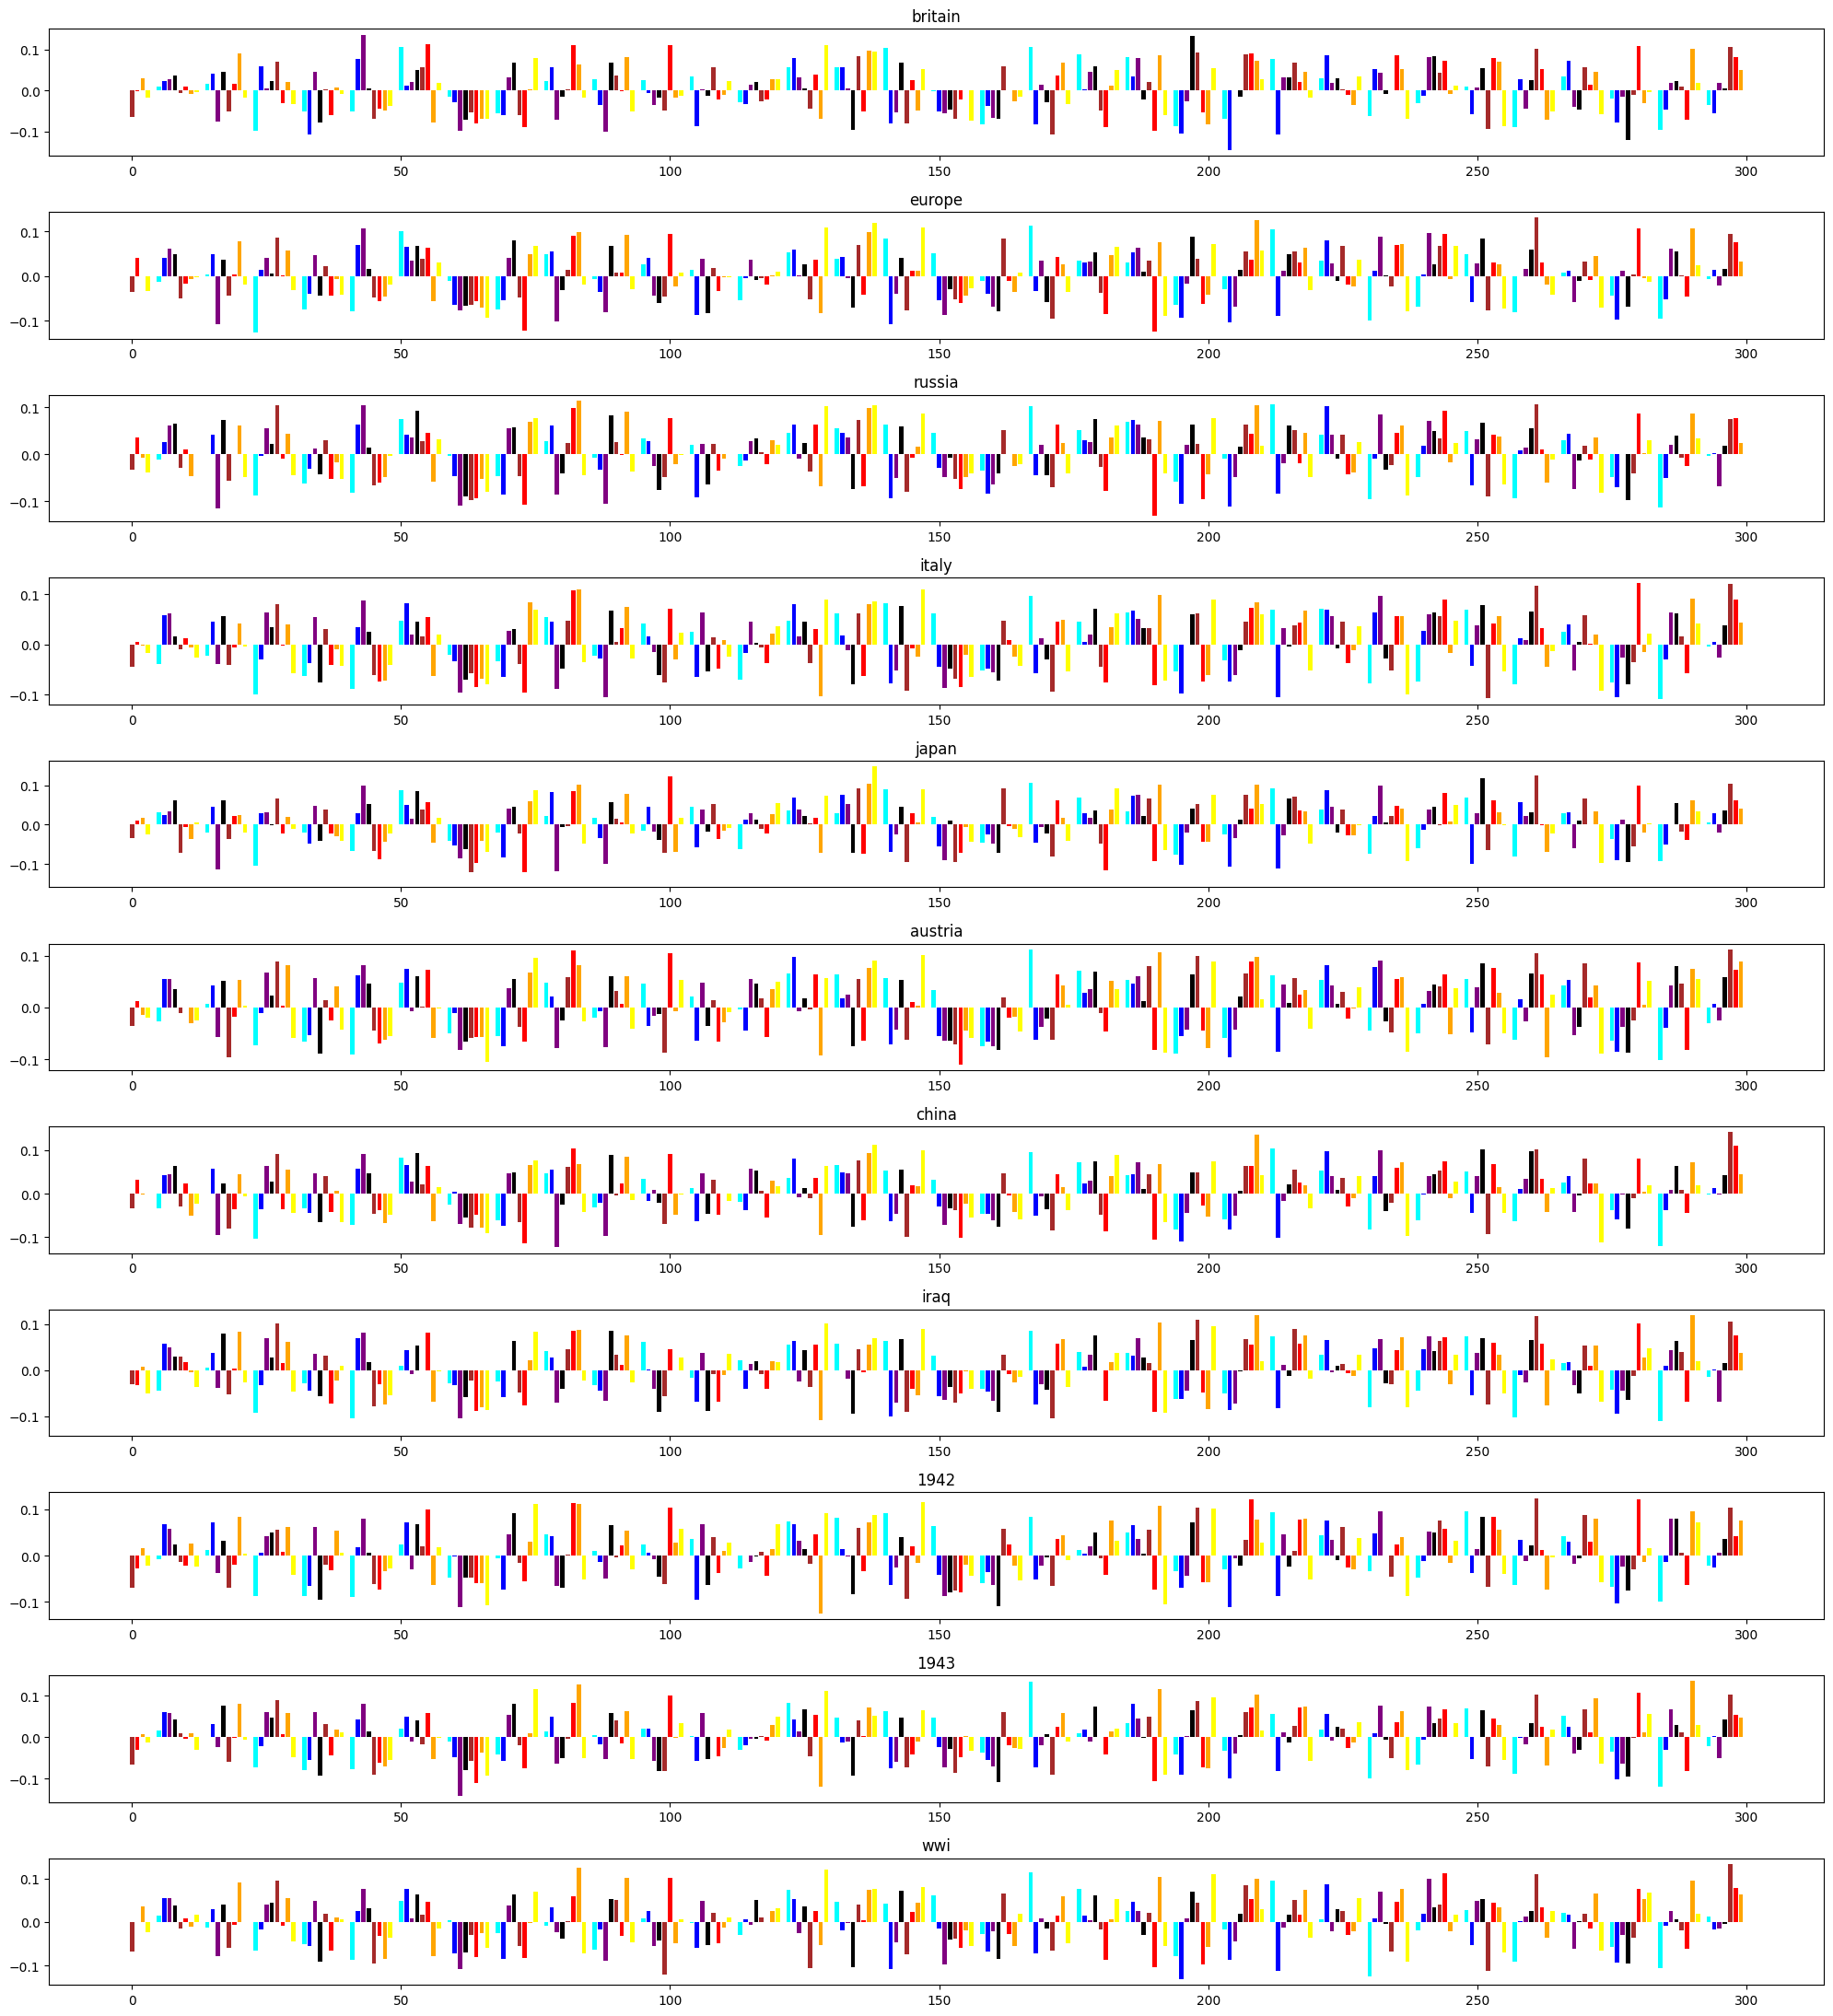

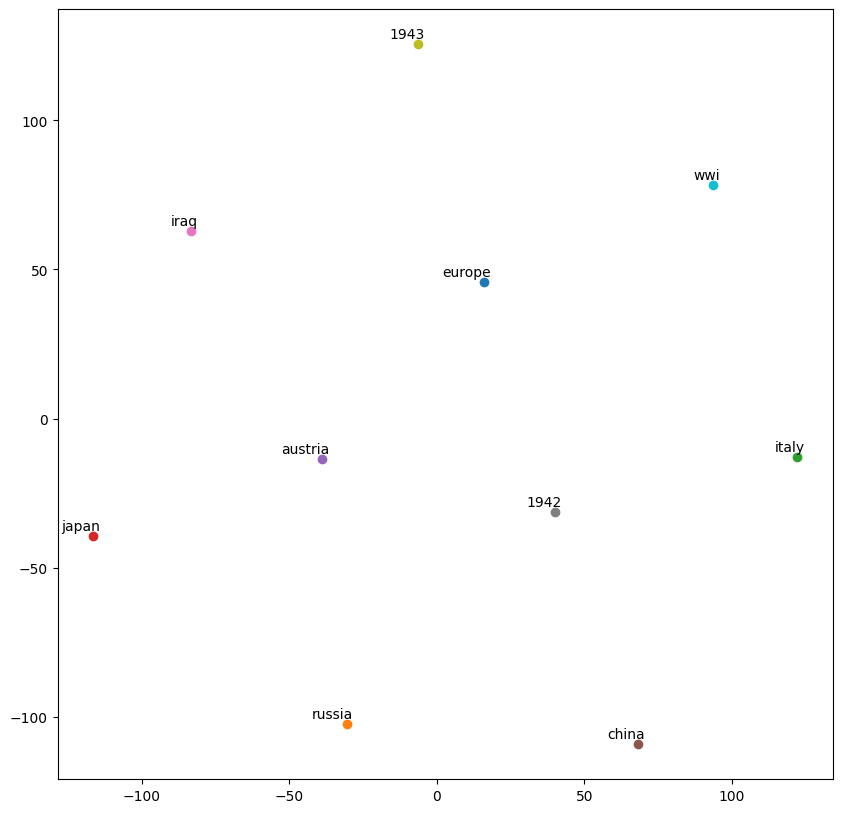

In [17]:

# words = ['ship', 'begin', 'well', 'great', 'my']
# for word in words:
plot_top10_words('britain', cbow_own)


Word not in vocabulary


10it [00:00, 40060.21it/s]

Word:  <UNK>
Top 10 similar words:  ['pel', 'la', 'iacute', 'asi', 'cula', 'hace', 'eacute', 'esta', 'bonita', 'amor']


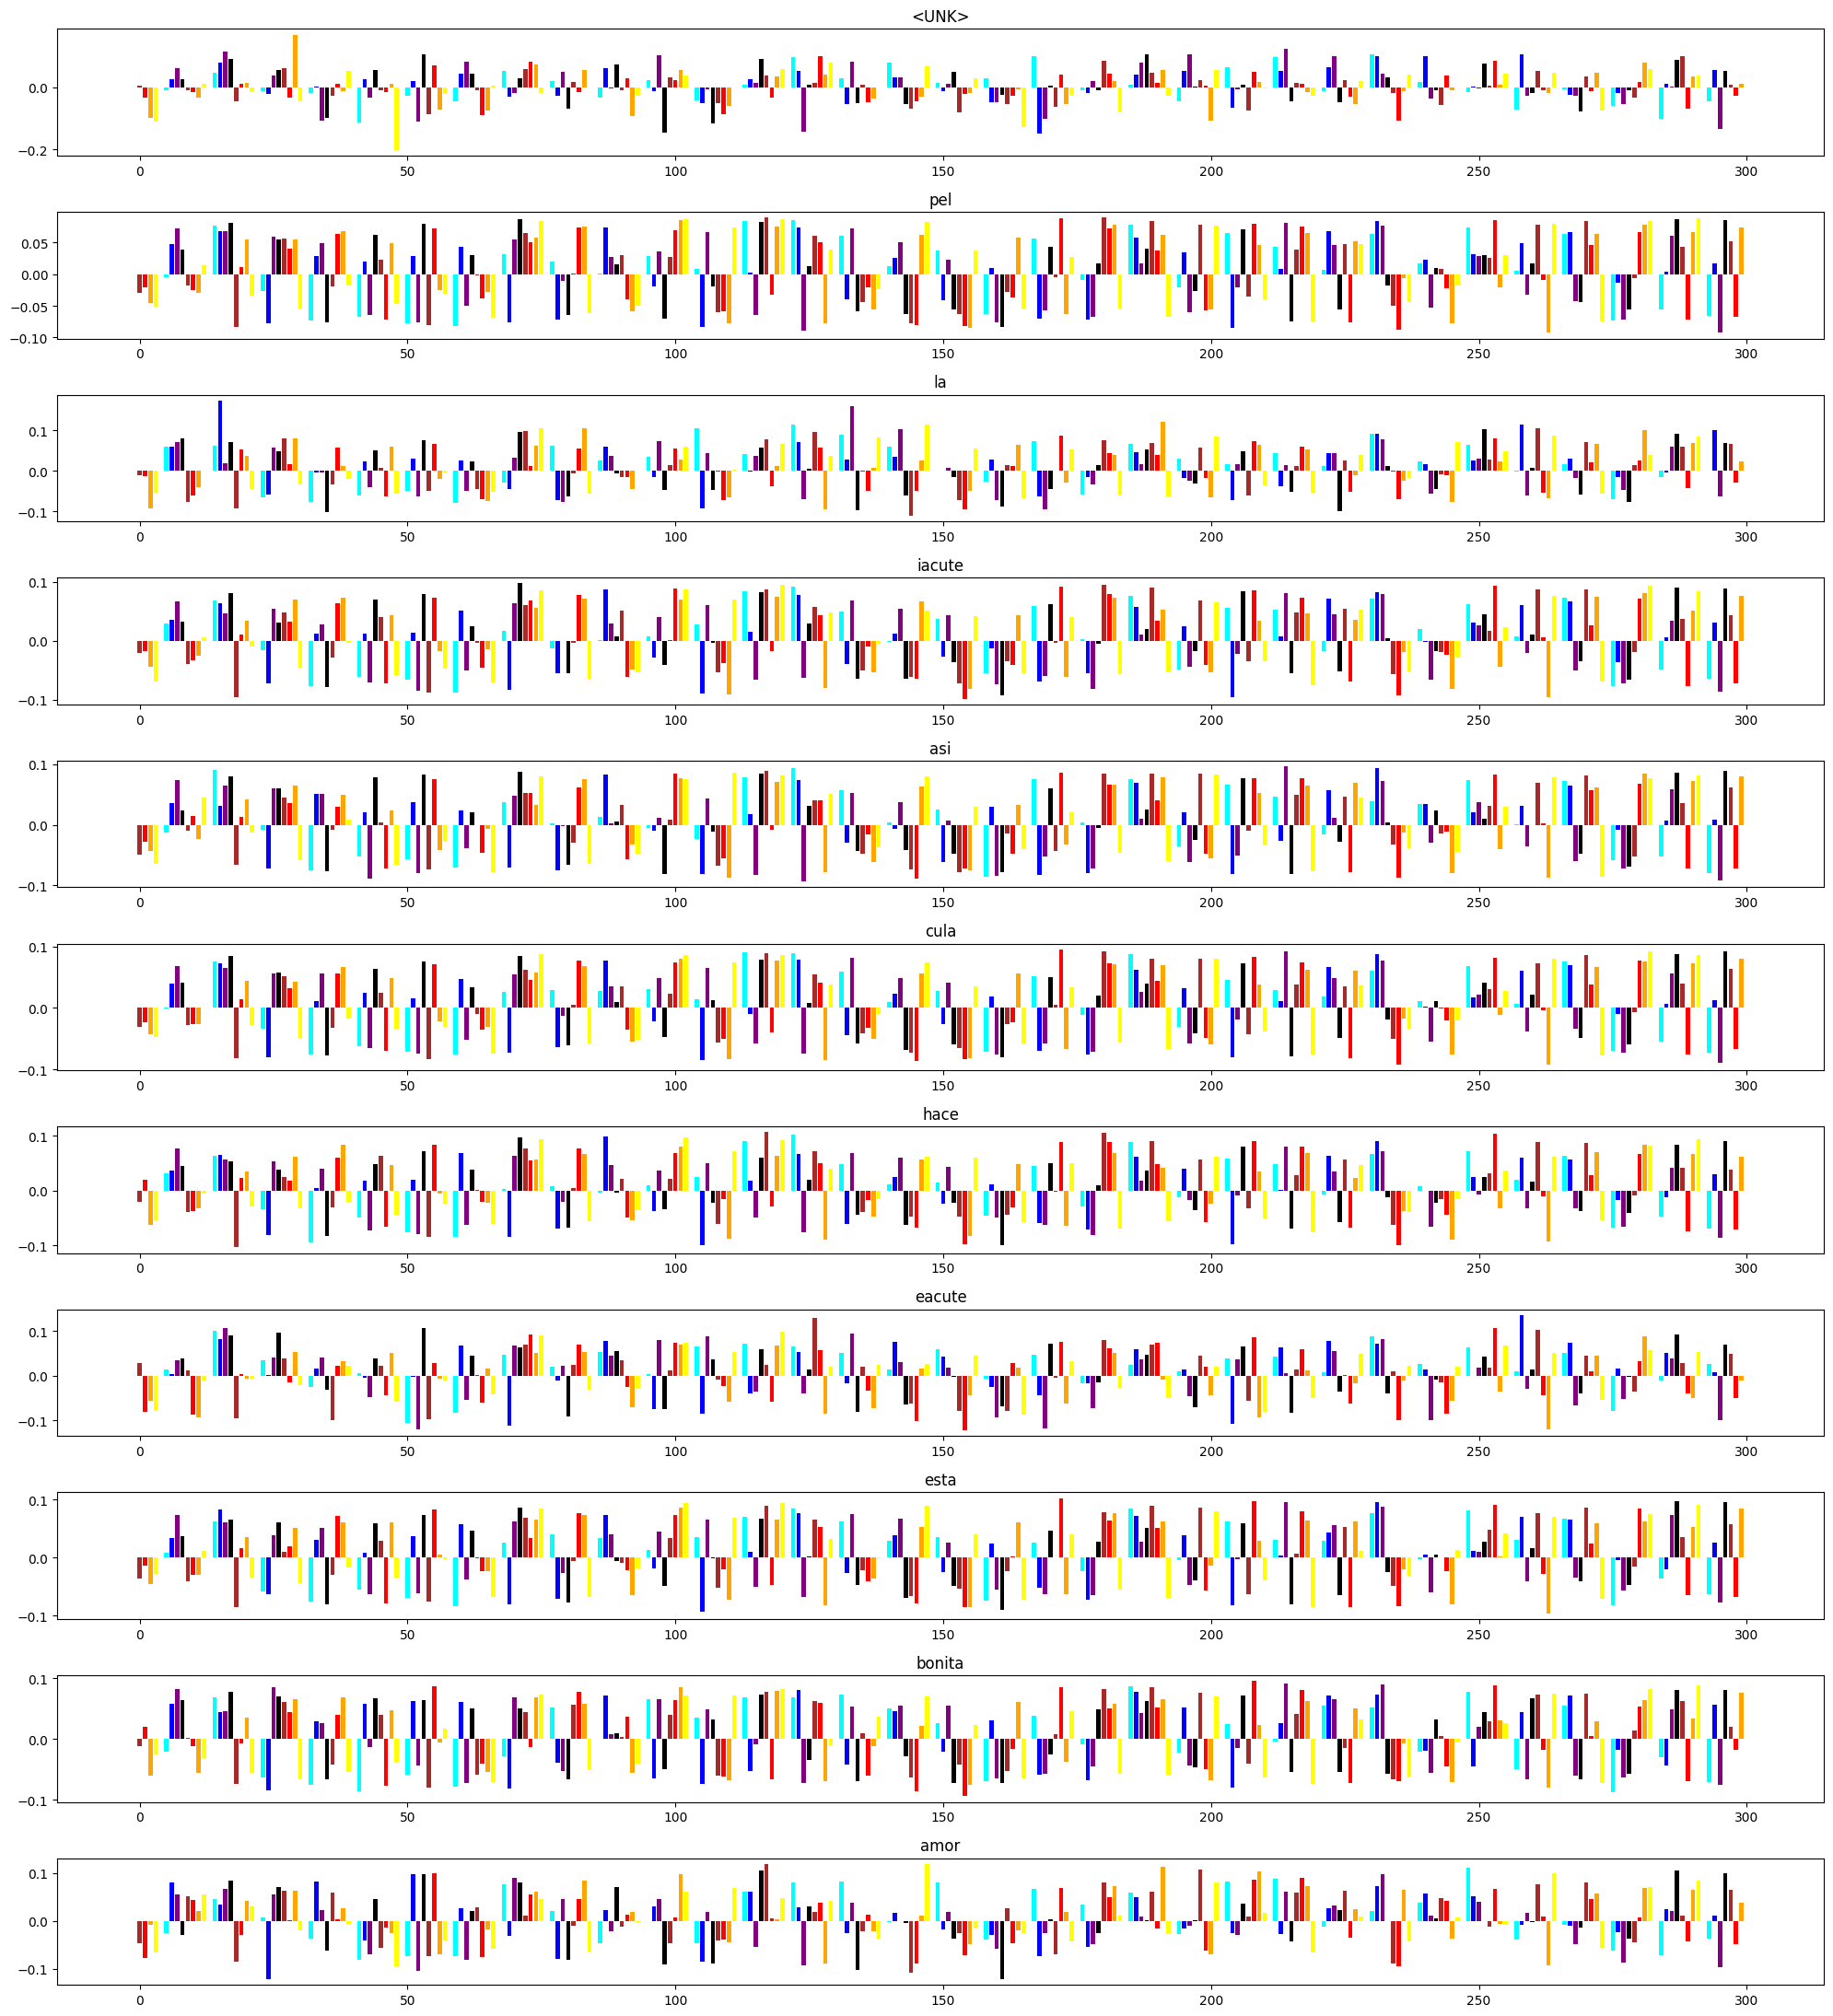

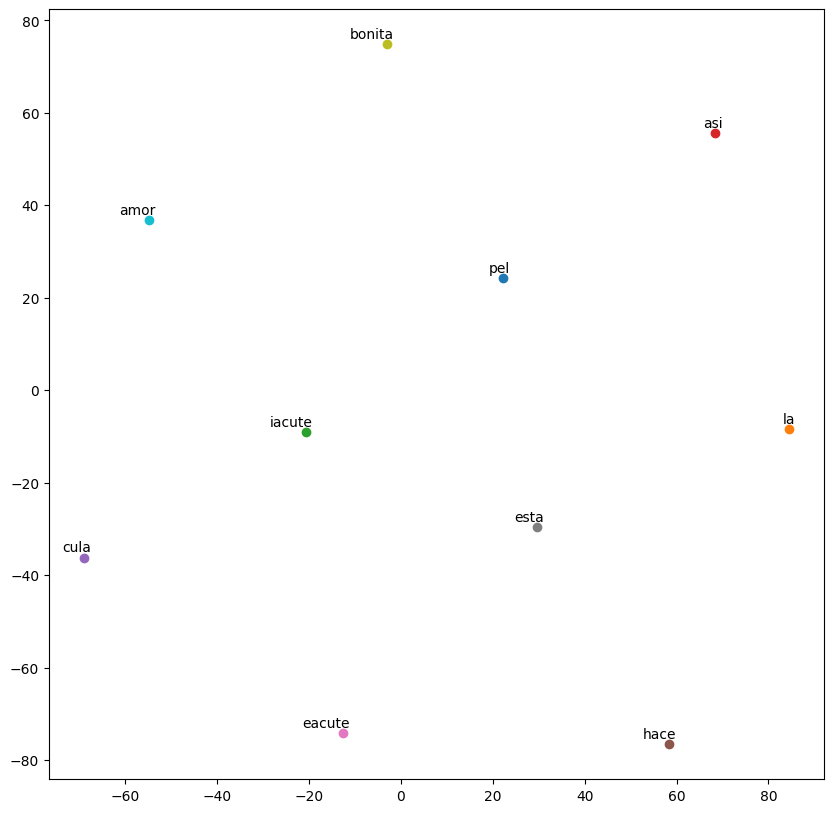

In [24]:
plot_top10_words('abhi', cbow_own)


10it [00:00, 1203.32it/s]


Word:  ship
Top 10 similar words:  ['subway', 'mount', 'plane', 'island', 'aircraft', 'bomb', 'patrol', 'coast', 'infantry', 'beach']


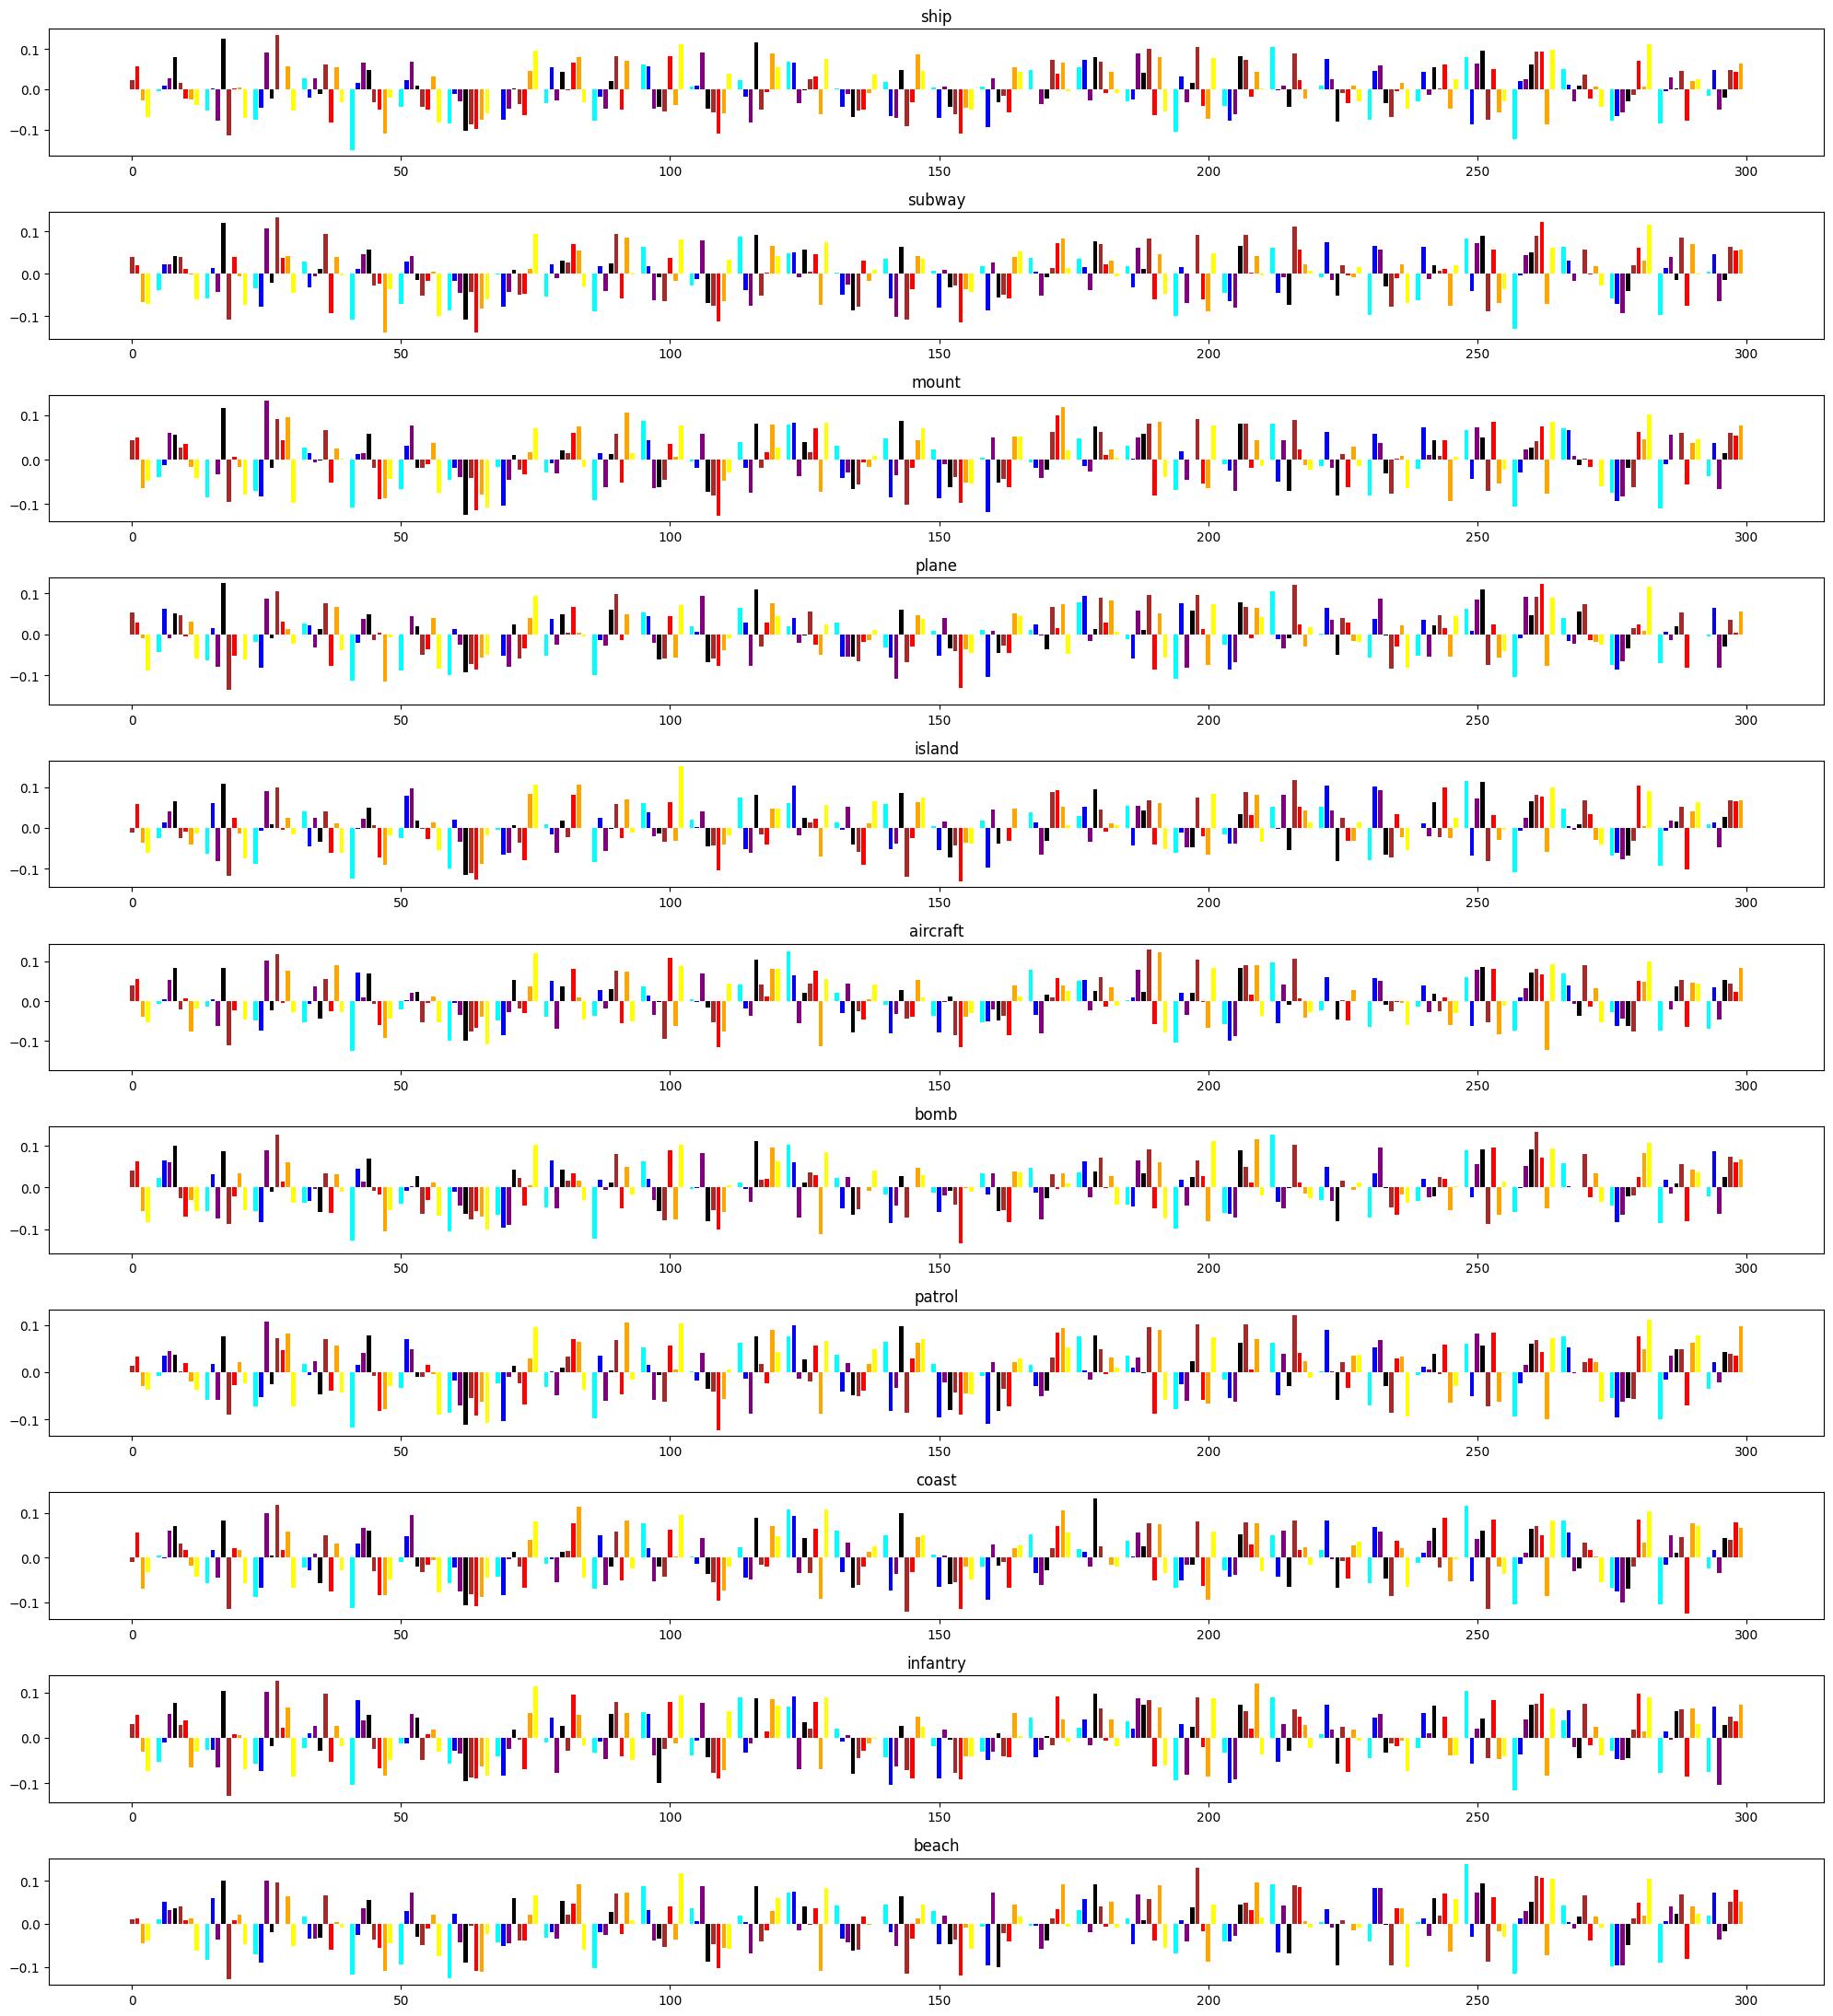

10it [00:00, 1391.51it/s]


Word:  his
Top 10 similar words:  ['their', 'her', 'thier', 'whose', 'goose', 'stepford', 'our', 'himself', 'grudgingly', 'your']


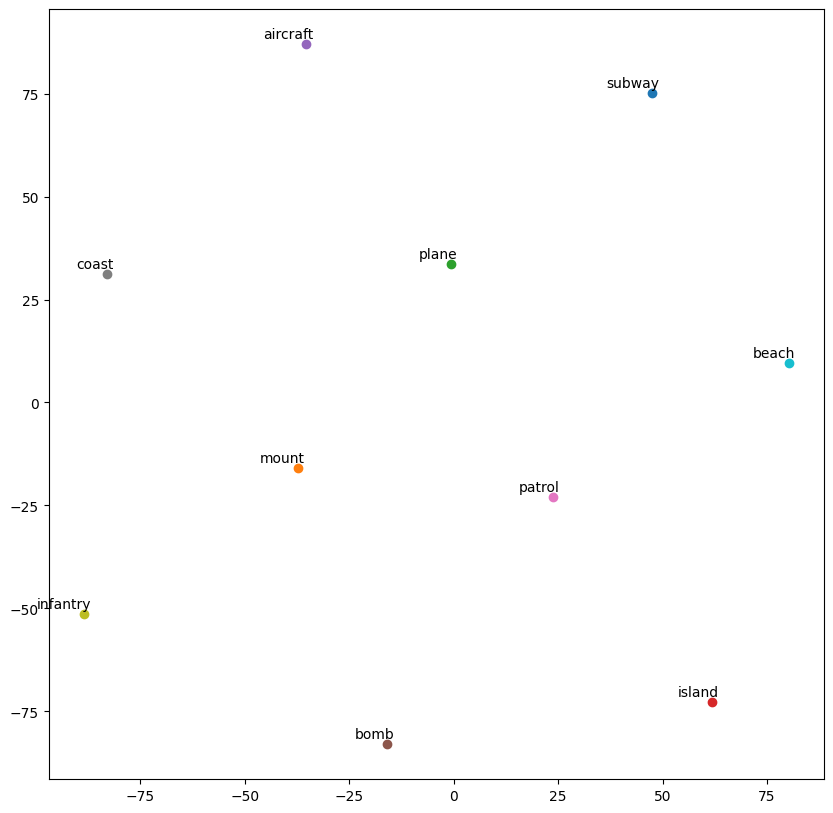

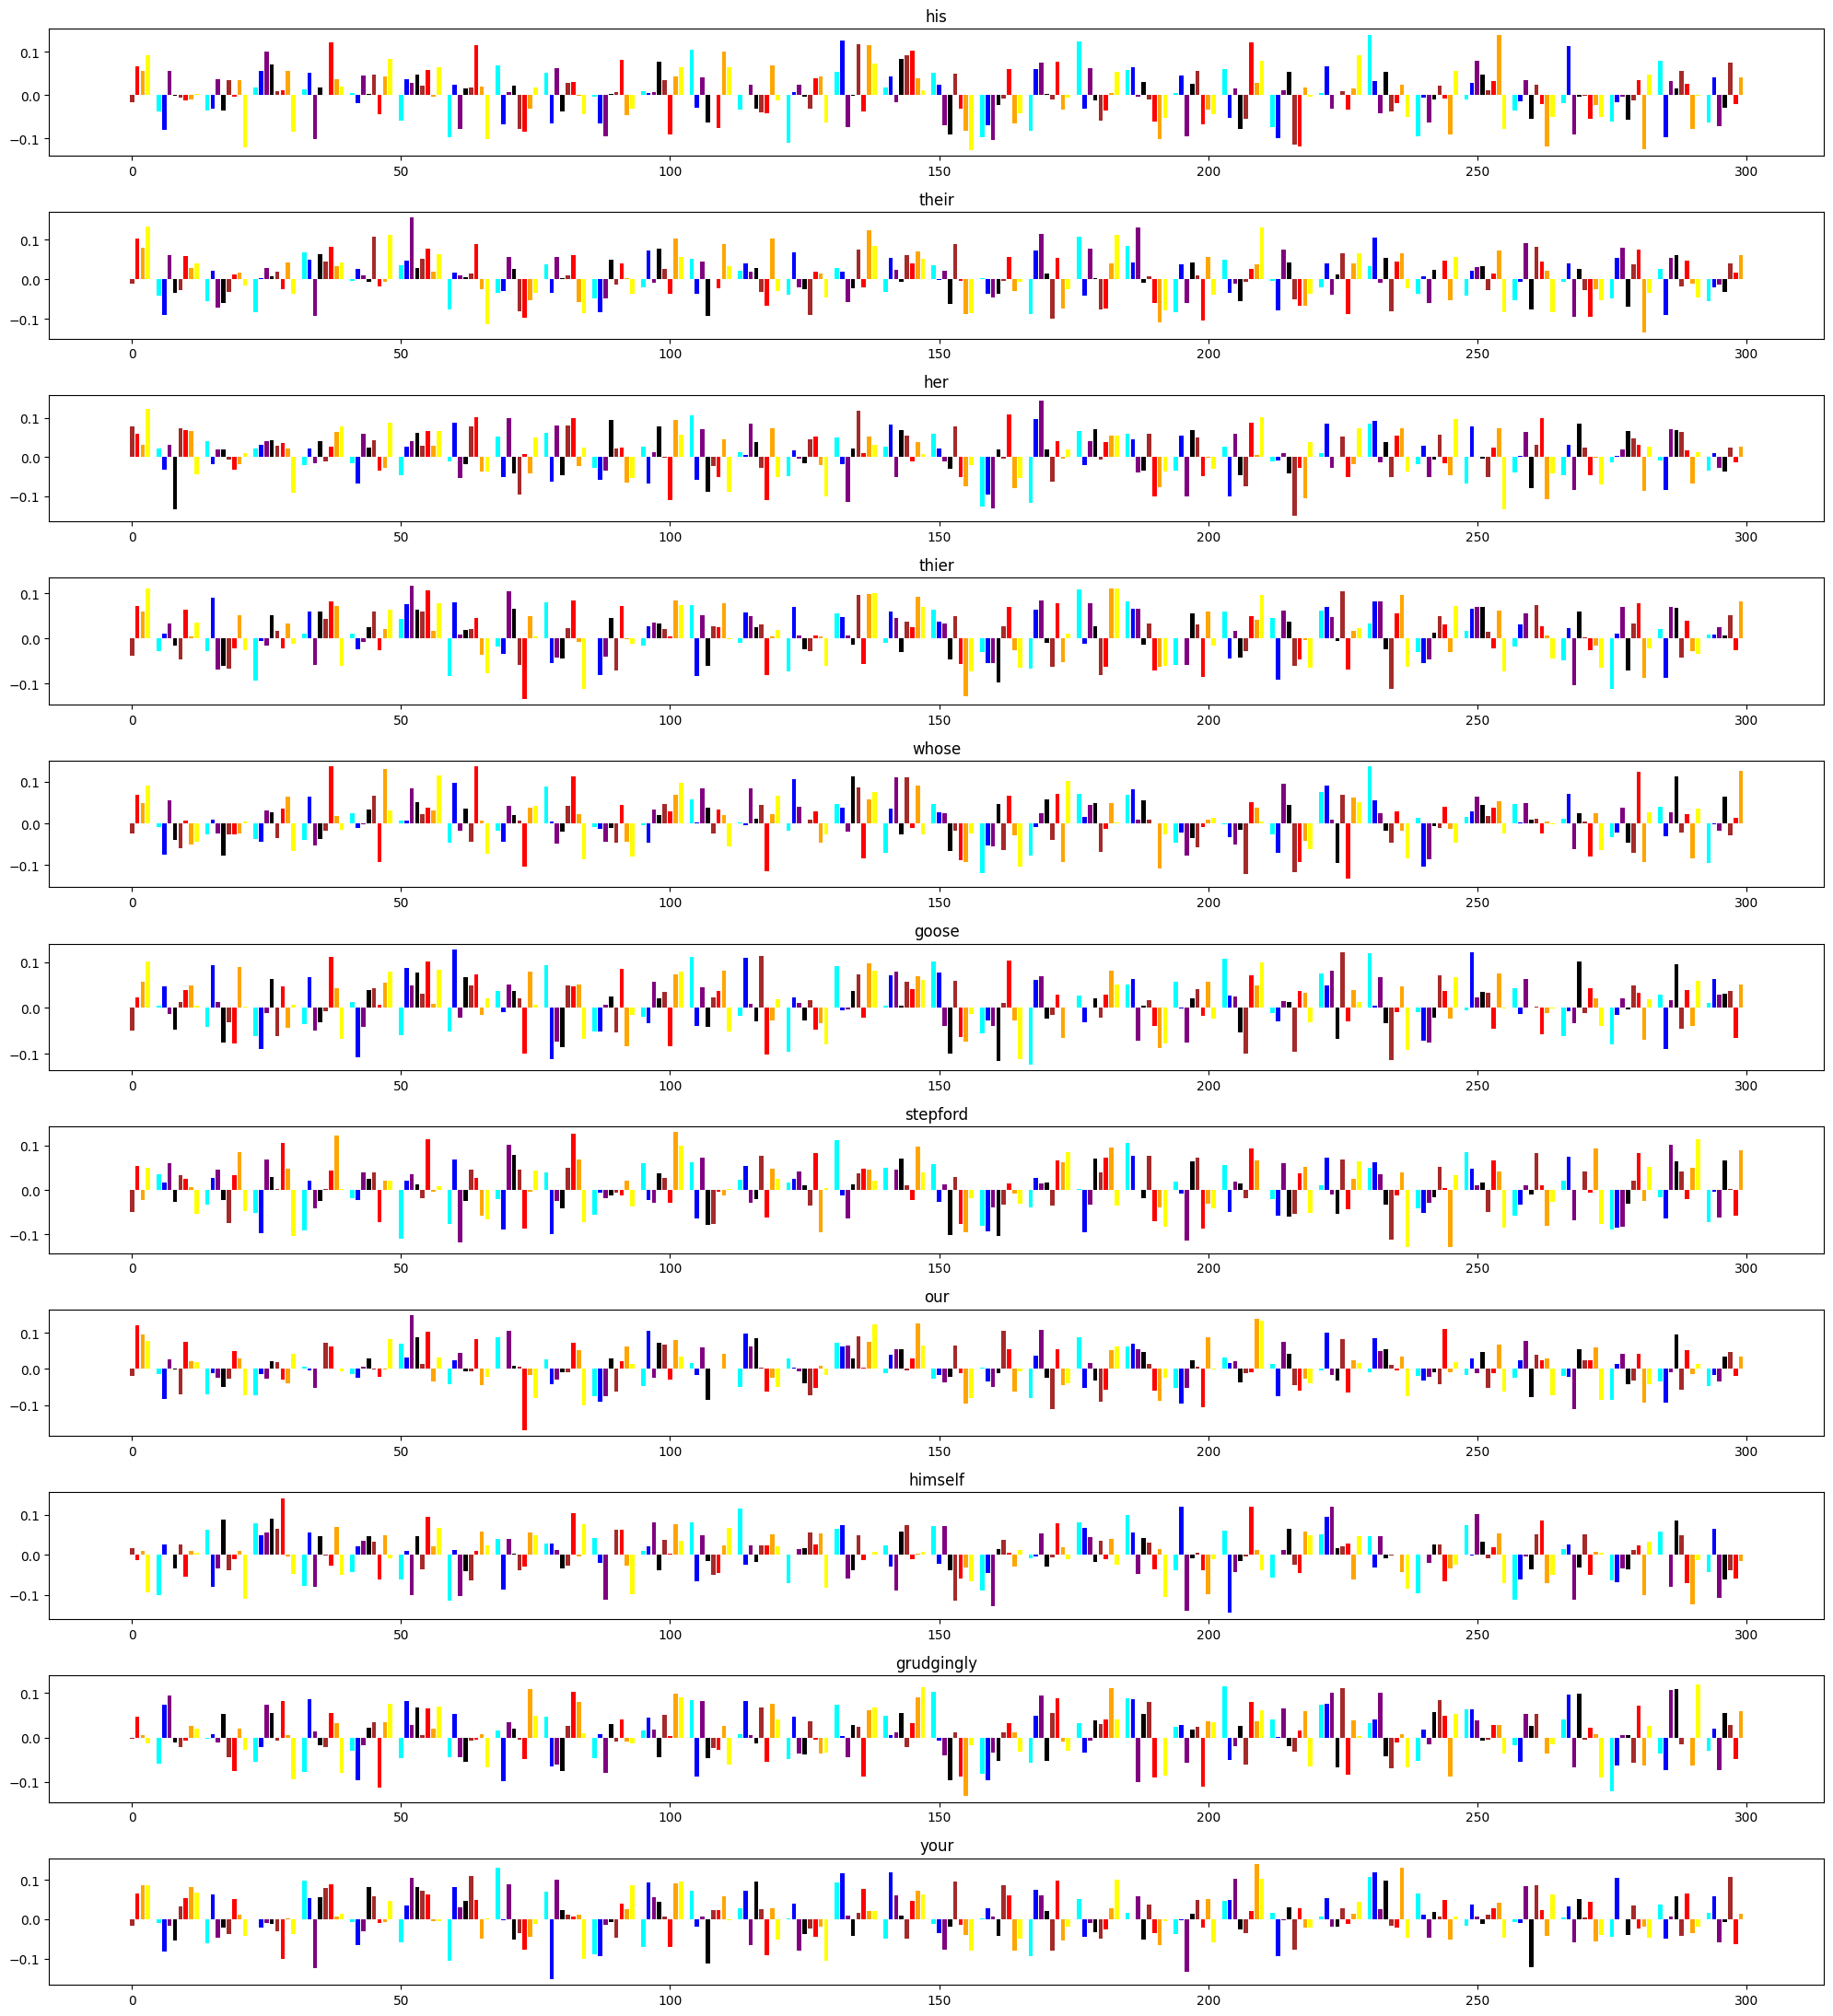

10it [00:00, 449.51it/s]


Word:  great
Top 10 similar words:  ['wonderful', 'fantastic', 'terrific', 'good', 'fabulous', 'fine', 'marvelous', 'superb', 'excelent', 'splendid']


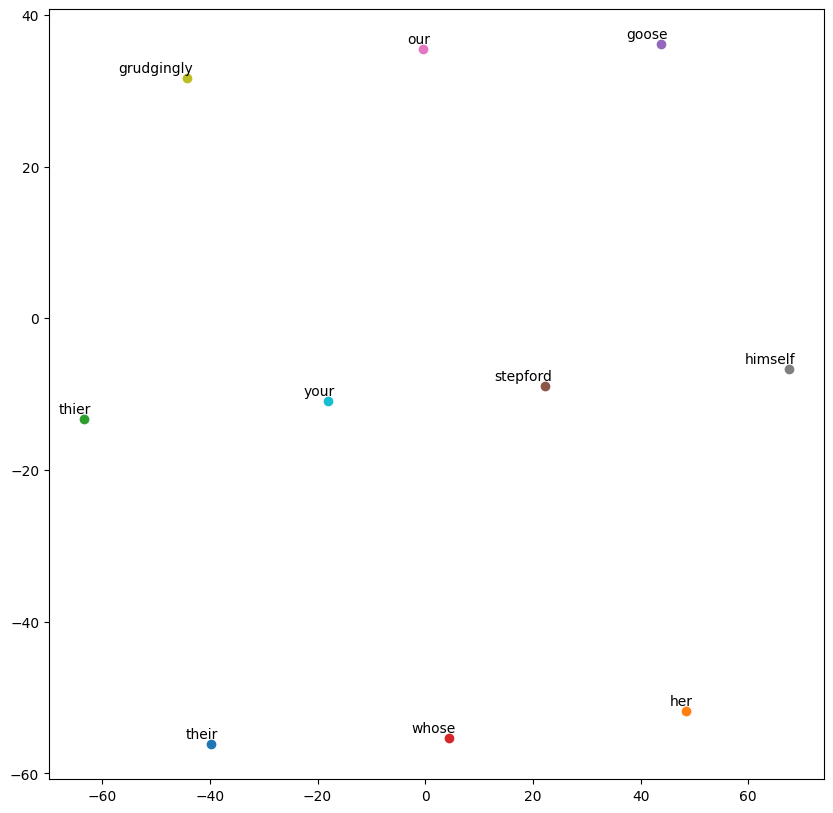

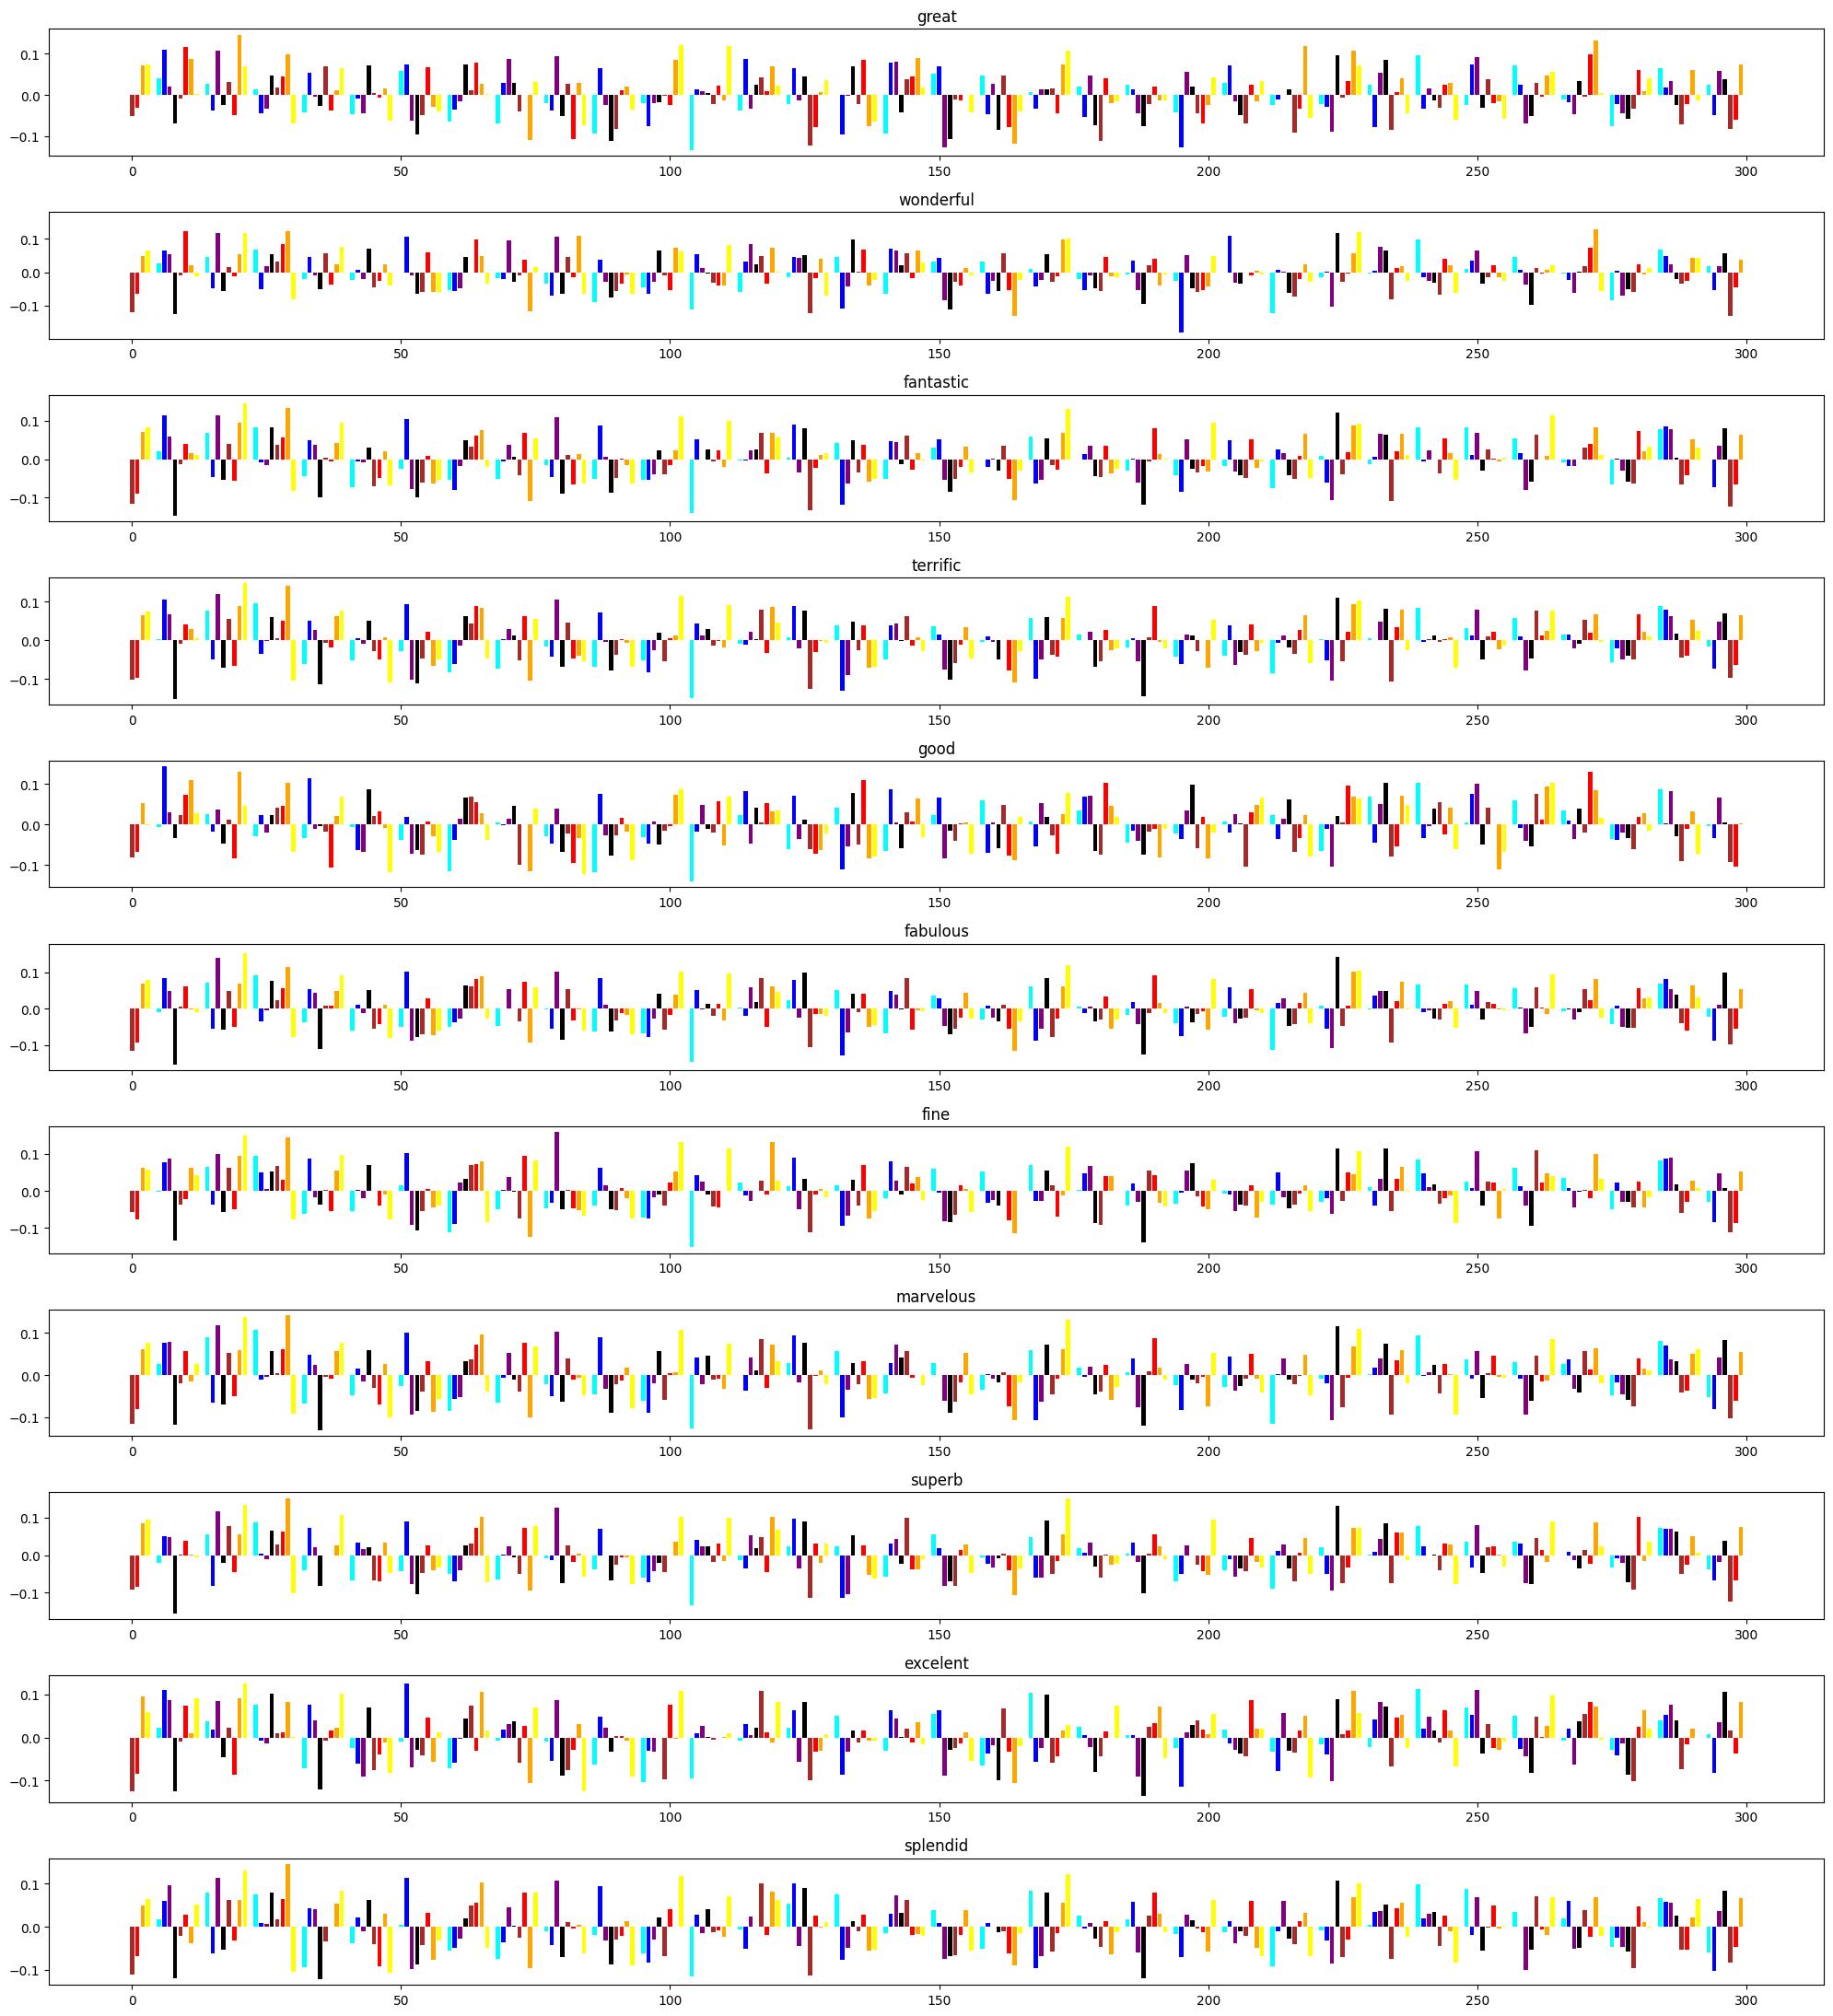

10it [00:00, 1164.92it/s]


Word:  well
Top 10 similar words:  ['poorly', 'badly', 'nicely', 'beautifully', 'tastefully', 'professionally', 'wonderfully', 'cheaply', 'brilliantly', 'perfectly']


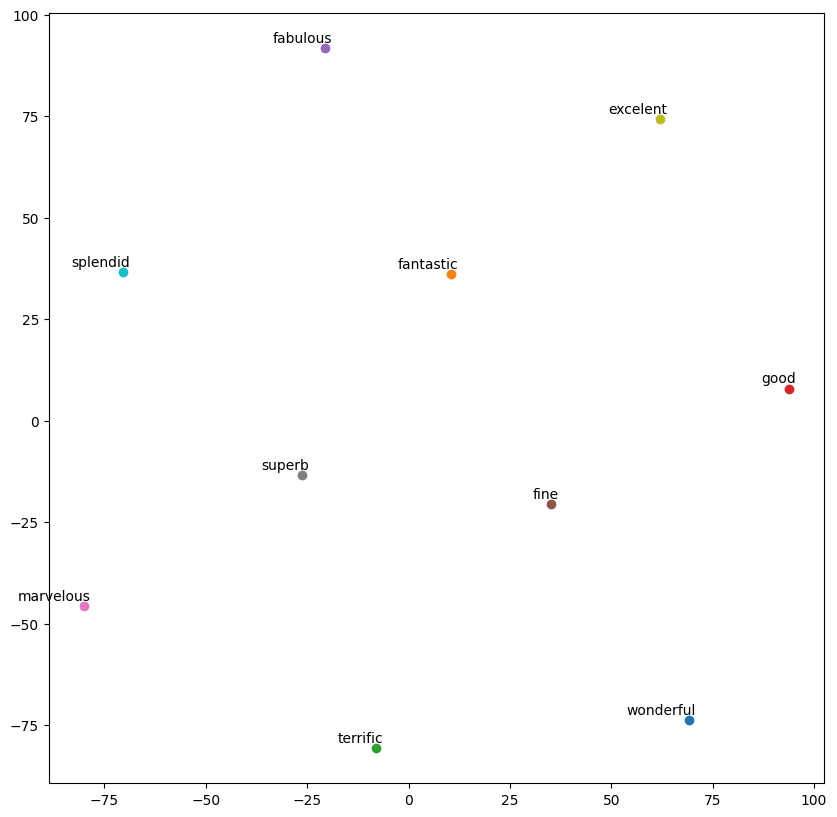

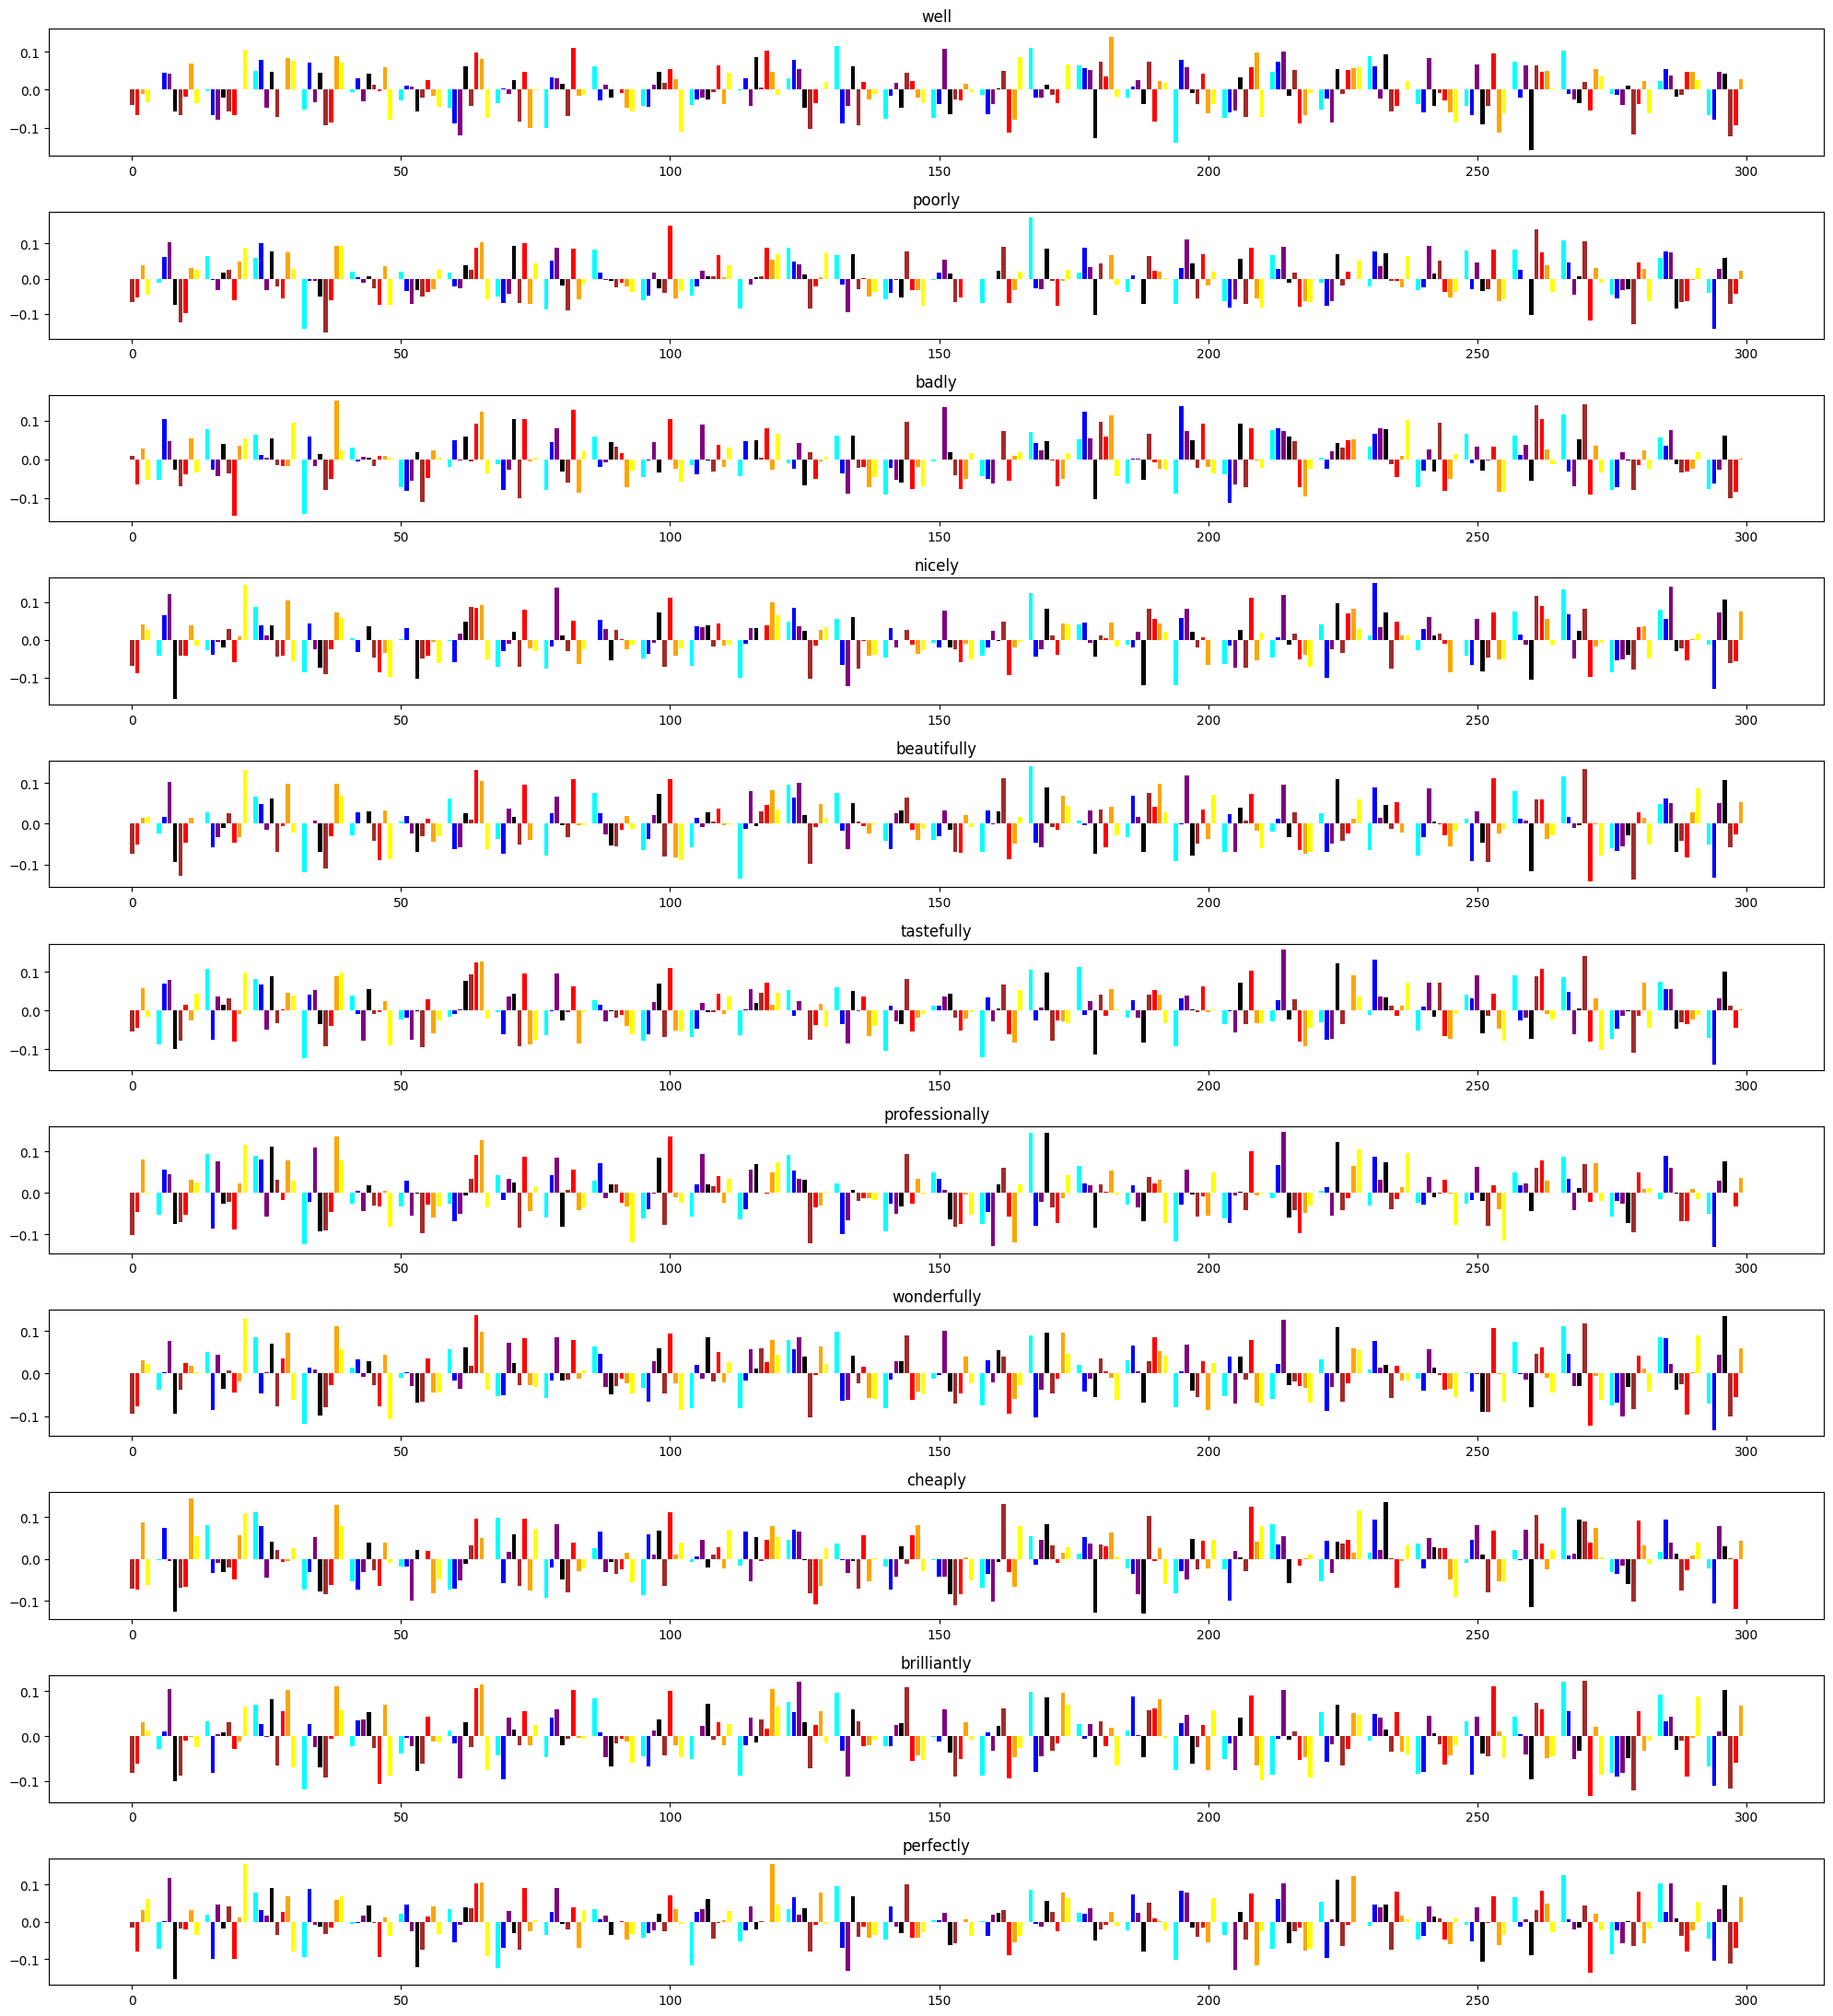

10it [00:00, 1058.26it/s]


Word:  start
Top 10 similar words:  ['finish', 'begin', 'stay', 'walk', 'jump', 'bounce', 'go', 'stick', 'hang', 'fade']


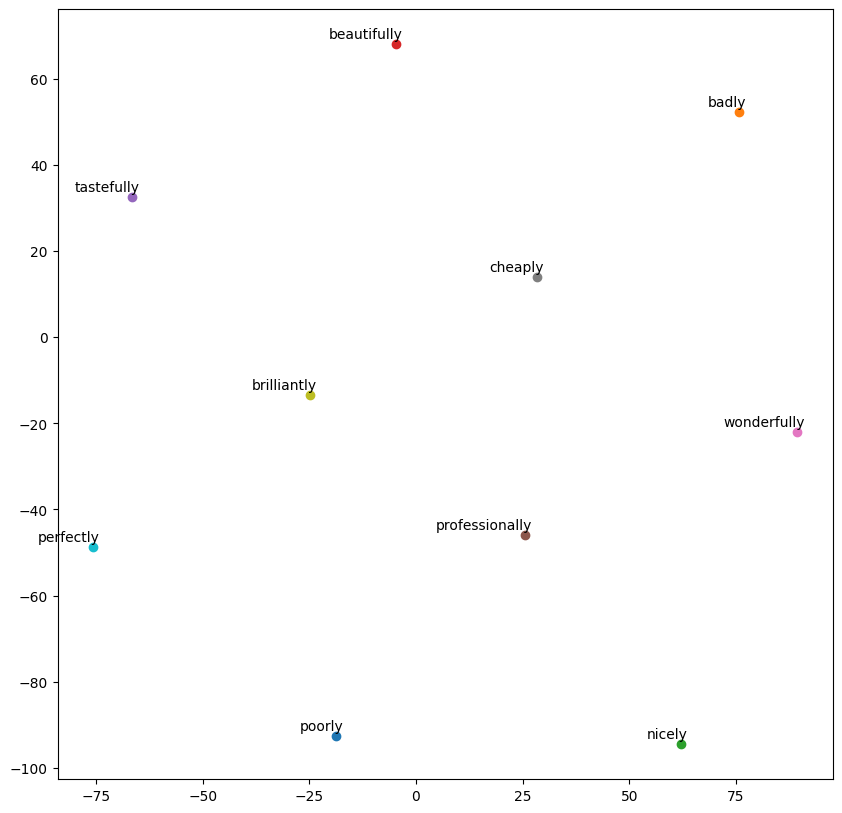

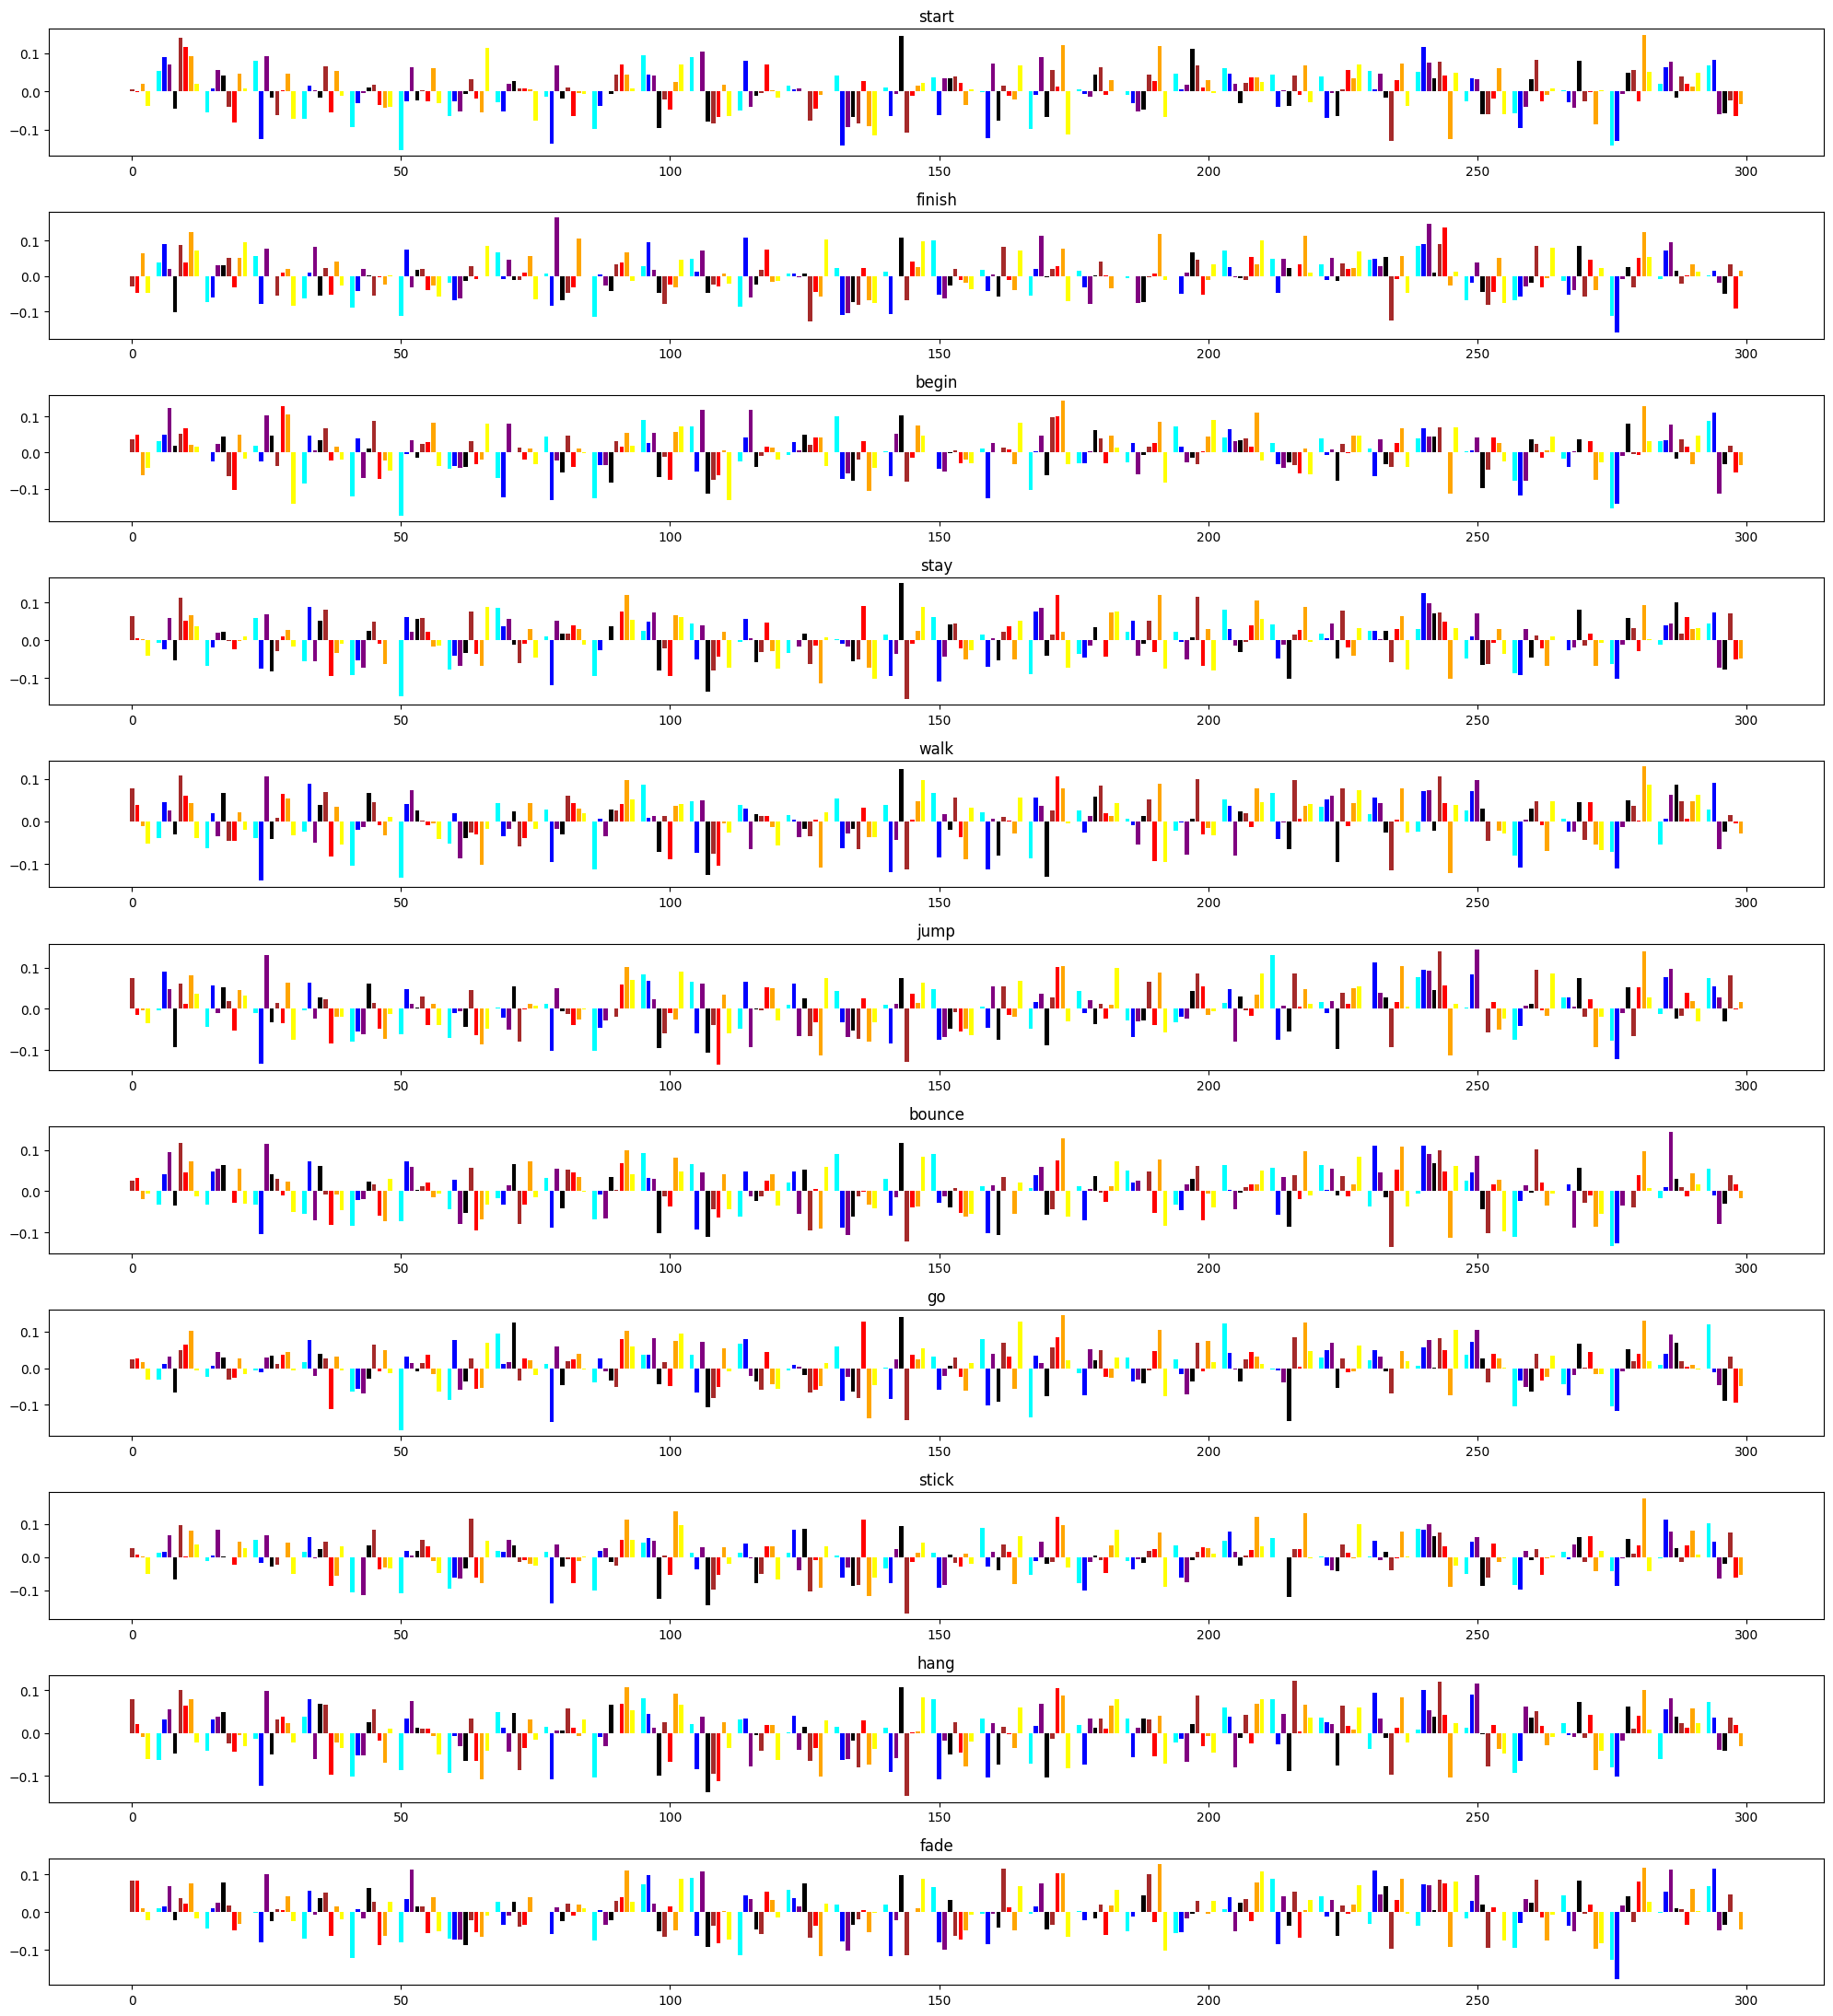

10it [00:00, 2673.40it/s]


Word:  titanic
Top 10 similar words:  ['craze', 'novella', '1970s', '1990s', 'ninety', 'article', 'ww', 'bbc', 'starrcade', 'seventy']


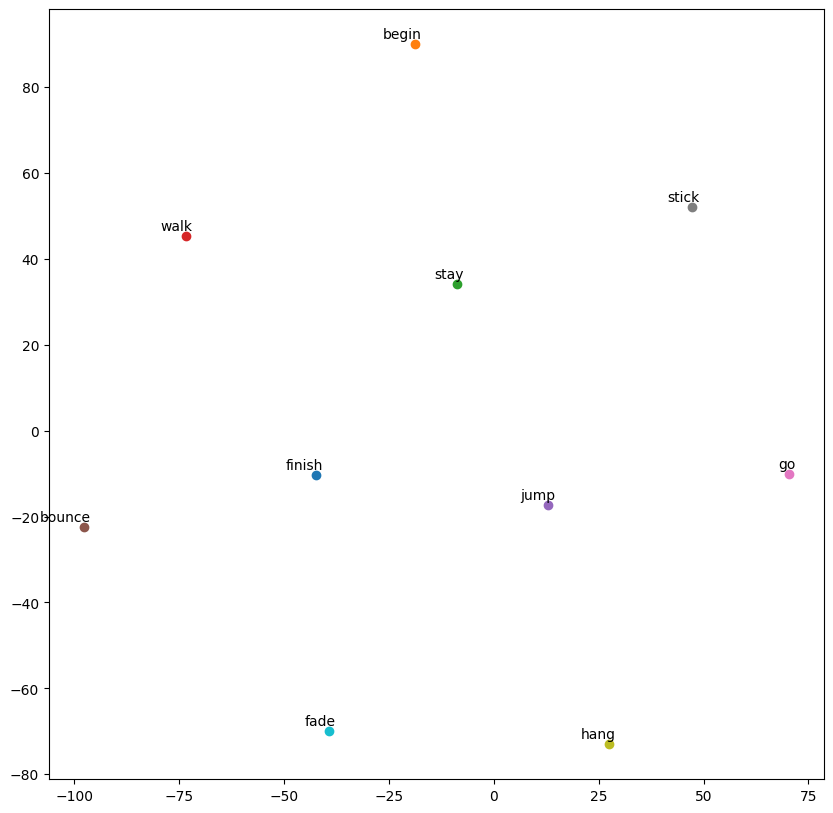

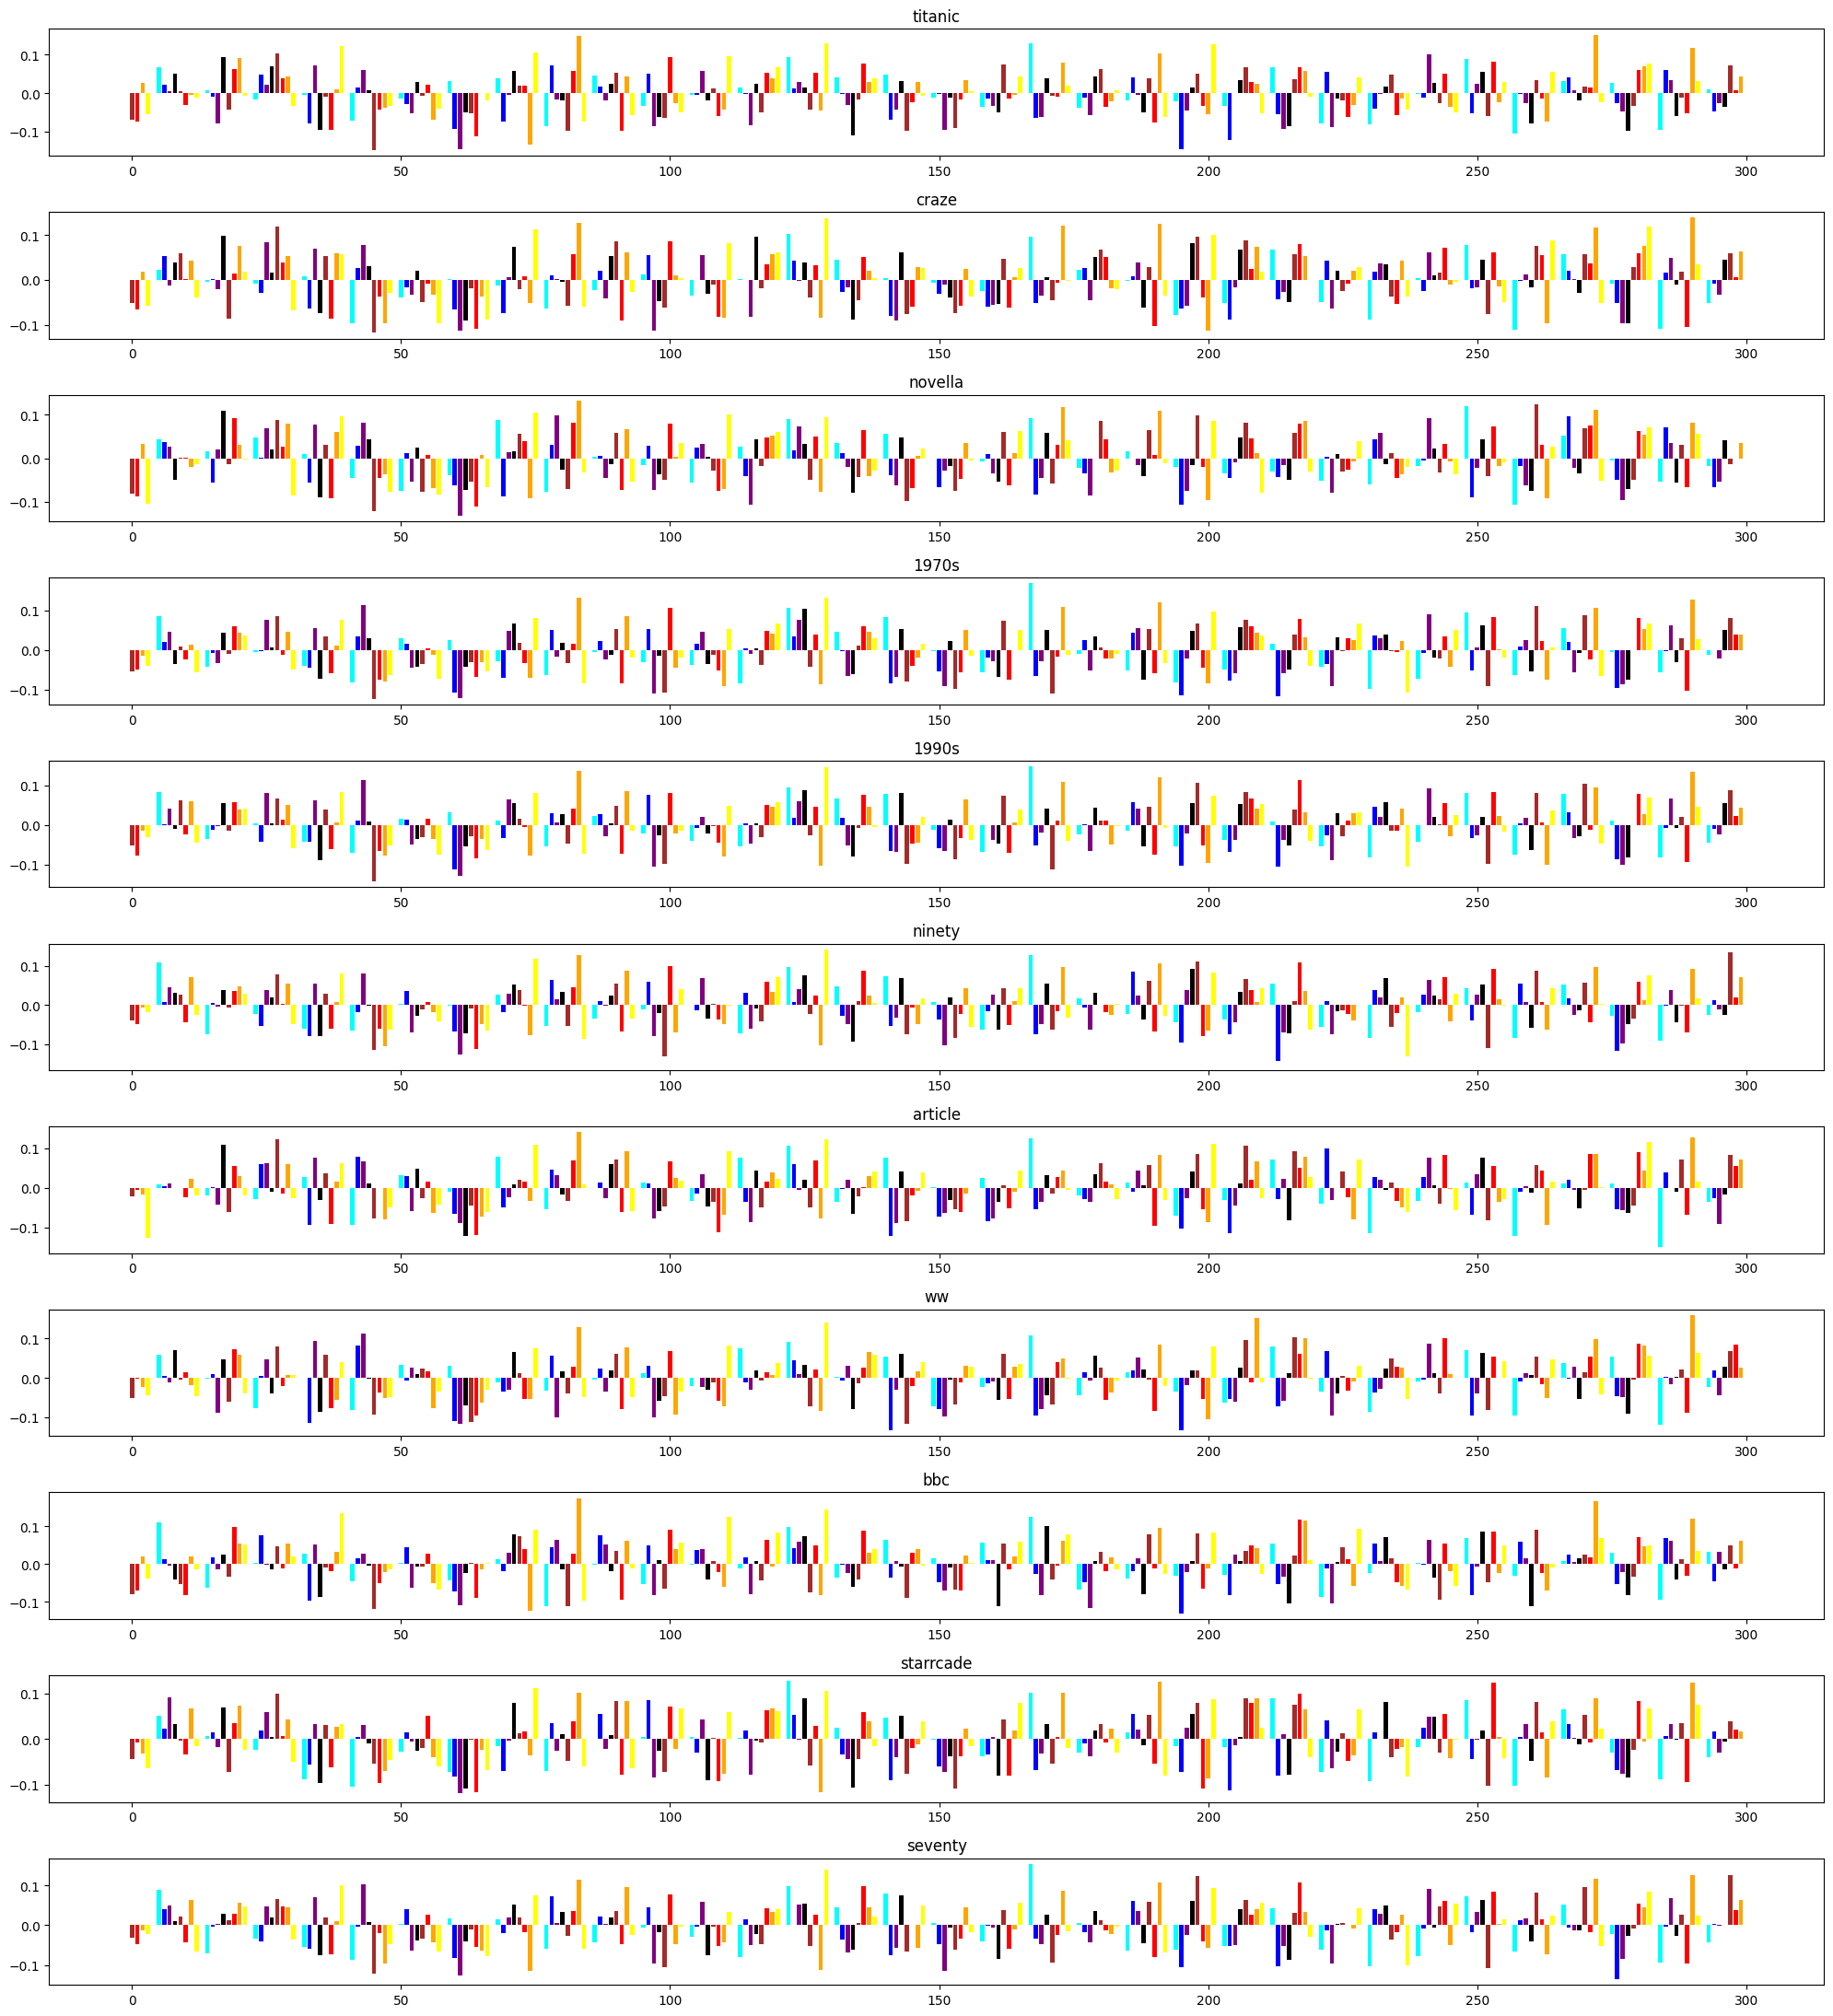

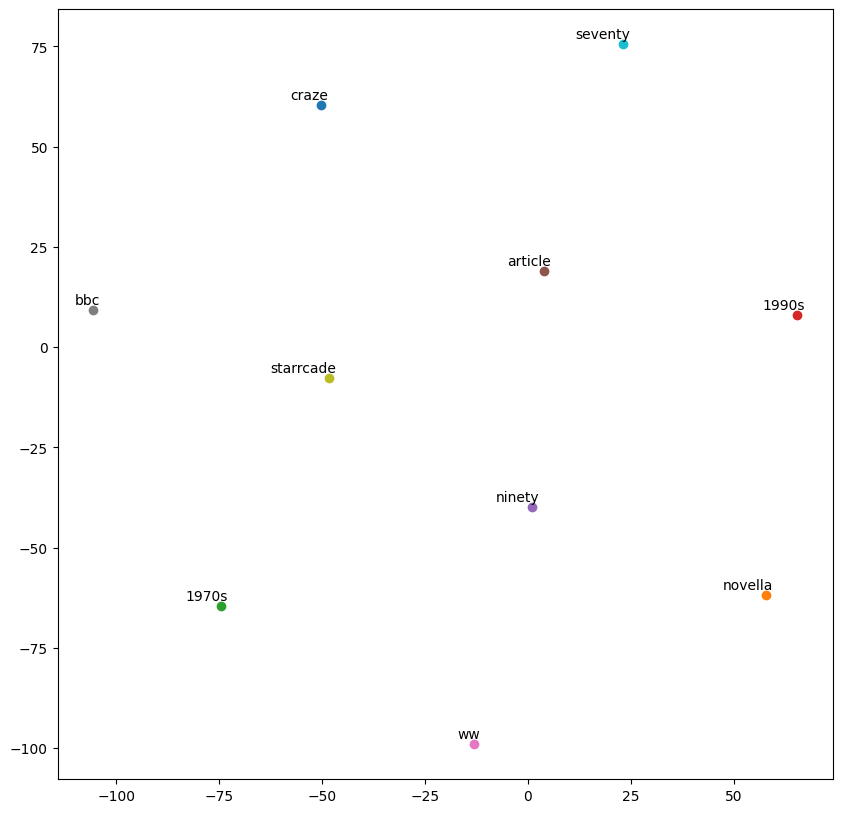

In [20]:
words = ['ship', 'his', 'great', 'well', 'start', 'titanic']
for word in words:
    plot_top10_words(word, cbow_own)